## Setup

Before getting started, import the necessary packages:

In [1]:
#!python -m pip install tensorflow

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [2]:
#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
print(logdir)

C:\Users\fstri\AppData\Local\Temp\tmpdk_h4s3_\tensorboard_logs


# FMNS: Try modeling our candles

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
#import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final,\
                                    generateFeatures_multi_v1

from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing,\
                                                    extract_labels_multi_final,\
                                                    align_features_and_labels_multi_final

from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction
from utils.plotting import plot_confusion_matrix

In [6]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
#     path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
    path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    data = pd.read_csv(path + '/' + datafiles[int(file)],
                       header = None,
                       names=['open','high','low','close',
                              'spread_open','spread_high','spread_low','spread_close',
                              'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                              'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                              'Ticker'])
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

Which one do you want to load? 

0: aggregateTAQ_10sec.csv
1: aggregateTAQ_30sec.csv
2: aggregateTAQ_60sec.csv


2


In [7]:
# add ticker as a multiindex or just groupby directly on date & ticker
data #.index

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [8]:
for i, ticker in enumerate(data.Ticker.unique()):
    print(i, ticker)

0 AAPL
1 ABBV
2 ABT
3 AEP
4 AMT
5 APD
6 BA
7 BABA
8 BAC
9 BHP
10 BP
11 CCI
12 CHL
13 COST
14 CSGP
15 D
16 DIS
17 ECL
18 ENB
19 EXC
20 FB
21 FMX
22 GOOG
23 IDU
24 INTC
25 IYC
26 IYE
27 IYG
28 IYH
29 IYJ
30 IYK
31 IYM
32 IYR
33 IYW
34 IYZ
35 JNJ
36 KO
37 LFC
38 LIN
39 LMT
40 MA
41 MCD
42 MSFT
43 NKE
44 NVDA
45 NVS
46 PBR
47 PEP
48 PFE
49 PLD
50 PSA
51 PTR
52 PYPL
53 RTX
54 SHW
55 SNP
56 SO
57 SRE
58 T
59 TM
60 TSLA
61 TSM
62 UNP
63 UPS
64 V
65 WMT


In [9]:
data[data.Ticker=='TSLA']

open     high      low    close  spread_open  spread_high  \
20200501 0    755.140  762.530  753.500  762.215         1.72         4.42   
         1    762.265  763.480  755.065  757.875         1.47         5.91   
         2    757.875  760.225  756.795  758.915         1.33         3.58   
         3    758.920  764.795  755.985  764.475         0.82         3.20   
         4    764.475  772.745  764.130  770.750         1.05         2.98   
...               ...      ...      ...      ...          ...          ...   
20200529 385  833.135  834.920  833.060  834.560         0.47         0.70   
         386  834.635  834.970  834.060  834.160         0.31         0.54   
         387  834.170  834.175  832.420  832.610         0.26         0.64   
         388  832.615  833.965  832.615  833.900         0.19         0.76   
         389  833.895  834.395  833.780  834.145         0.19         0.47   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.02          1.37           1.0           7.0   
         1          0.13          1.33           1.0           7.0   
         2          0.01          0.81           2.0          10.0   
         3          0.01          1.05           1.0          10.0   
         4          0.01          0.84           1.0          20.0   
...                  ...           ...           ...           ...   
20200529 385        0.04          0.46           1.0           6.0   
         386        0.02          0.24           1.0           6.0   
         387        0.03          0.20           3.0          16.0   
         388        0.04          0.20           1.0          10.0   
         389        0.01          0.17           1.0         120.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0            1.0           5.0          26.0   
         1            1.0            2.0          15.0          15.0   
         2            1.0            1.0           2.0           7.0   
         3            1.0            1.0           4.0          30.0   
         4            1.0            1.0          31.0          31.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            3.0           1.0         113.0   
         386          1.0            3.0           1.0          87.0   
         387          1.0            1.0           1.0          26.0   
         388          1.0            1.0           2.0          31.0   
         389          1.0           90.0           2.0          53.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            2.0   TSLA  
         1            1.0            1.0   TSLA  
         2            1.0            1.0   TSLA  
         3            1.0           30.0   TSLA  
         4            1.0            1.0   TSLA  
...                   ...            ...    ...  
20200529 385          1.0            1.0   TSLA  
         386          1.0            1.0   TSLA  
         387          1.0            2.0   TSLA  
         388          1.0           29.0   TSLA  
         389          1.0           28.0   TSLA  

[7800 rows x 17 columns]

In [10]:
########### Generate Features ################

#ticker_to_model = 'TSLA'
#candles = data[data.Ticker==ticker_to_model]

n_feature_lags = 1
# features = generateFeatures_final(data = candles, 
#                                   listOfFeatures = [
#                                                     'pastobs',
#                                                     'spread',
#                                                     'bidsize',
#                                                     'ofrsize',
# #                                                     'stok',
# #                                                     'stod',
# #                                                     'sstod',
# #                                                     'wilr',
# #                                                     'roc',
# #                                                     'rsi',
# #                                                     'atr',
# #                                                     'cci',
# #                                                     'dpo',
# #                                                     'sma',
# #                                                     'ema',
# #                                                     'macd',
# #                                                     'dis5',
# #                                                     'dis10',
#                                                    ], 
#                                    feature_lags = n_feature_lags)

features = generateFeatures_multi_v1(data = data, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
#                                                     'stok',
#                                                     'stod',
#                                                     'sstod',
#                                                     'wilr',
#                                                     'roc',
#                                                     'rsi',
#                                                     'atr',
#                                                     'cci',
#                                                     'dpo',
#                                                     'sma',
#                                                     'ema',
#                                                     'macd',
#                                                     'dis5',
#                                                     'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = data[['open','high','low','close','Ticker']]
#labels = extract_labels_multi_final(data = price_candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels_multi_final(price_candles = price_candles, 
                                             all_features = features,
                                             prediction_horizon = 1, 
                                             n_feature_lags = n_feature_lags, 
                                             n_classes = n_classes, # 5,
                                             safe_burn_in = False, 
                                             data_sample = 'full',splitType='global',noise=False)

['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AAPL done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABBV done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
ABT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AEP done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
AMT done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
APD done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BABA done
['open_lag0' 'open_lag1' 'high_lag0' 'high_lag1' 'low_lag0' 'low_lag1'
 'close_lag0' 'close_lag1']
BAC done
['open_lag0' 'open_lag1' '

..\utils\preprocessing_features_and_labels.py:698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burned_in_features['ticker'] = ticker_name


AAPL done
ABBV done
ABT done
AEP done
AMT done
APD done
BA done
BABA done
BAC done
BHP done
BP done
CCI done
CHL done
COST done
CSGP done
D done
DIS done
ECL done
ENB done
EXC done
FB done
FMX done
GOOG done
IDU done
INTC done
IYC done
IYE done
IYG done
IYH done
IYJ done
IYK done
IYM done
IYR done
IYW done
IYZ done
JNJ done
KO done
LFC done
LIN done
LMT done
MA done
MCD done
MSFT done
NKE done
NVDA done
NVS done
Number of NaNs in label: 1. 1 is expected
Returns that lead to NaNs in label: [0.0907158]
PBR done
PEP done
PFE done
PLD done
PSA done
PTR done
PYPL done
RTX done
SHW done
SNP done
SO done
SRE done
T done
TM done
TSLA done
TSM done
UNP done
UPS done
V done
WMT done


In [11]:
price_candles = data[['open','high','low','close','Ticker']]
price_candles

open     high      low    close Ticker
20200501 0    286.250  289.260  285.870  289.260   AAPL
         1    289.260  289.350  288.365  289.020   AAPL
         2    289.035  289.705  288.280  288.580   AAPL
         3    288.485  289.315  288.280  289.095   AAPL
         4    289.100  290.435  288.940  290.320   AAPL
...               ...      ...      ...      ...    ...
20200529 385  123.950  124.110  123.910  124.100    WMT
         386  124.085  124.085  123.920  123.995    WMT
         387  123.995  124.355  123.985  124.335    WMT
         388  124.335  124.355  124.060  124.075    WMT
         389  124.075  124.225  122.810  123.855    WMT

[514800 rows x 5 columns]

In [12]:
len(price_candles[price_candles.Ticker=='TSLA']['close'].values), price_candles[price_candles.Ticker=='TSLA']['close'].values

(7800, array([762.215, 757.875, 758.915, ..., 832.61 , 833.9  , 834.145]))

In [13]:
returns = ((price_candles[price_candles.Ticker=='TSLA']['close'].values[1:] / price_candles[price_candles.Ticker=='TSLA']['close'].values[:-1])-1)*100

In [14]:
len(returns), returns

(7799, array([-0.56939315,  0.1372258 ,  0.73262487, ..., -0.18581567,
         0.15493448,  0.02938002]))

## Sectors

In [15]:
stockInfo = pd.read_csv('../utils/stockInfo_v1.csv',header=[0,1])
stockInfo.columns = ['ticker','sector','exchange','marketCap']

In [16]:
X.ticker.unique()

array(['AAPL', 'ABBV', 'ABT', 'AEP', 'AMT', 'APD', 'BA', 'BABA', 'BAC',
       'BHP', 'BP', 'CCI', 'CHL', 'COST', 'CSGP', 'D', 'DIS', 'ECL',
       'ENB', 'EXC', 'FB', 'FMX', 'GOOG', 'IDU', 'INTC', 'IYC', 'IYE',
       'IYG', 'IYH', 'IYJ', 'IYK', 'IYM', 'IYR', 'IYW', 'IYZ', 'JNJ',
       'KO', 'LFC', 'LIN', 'LMT', 'MA', 'MCD', 'MSFT', 'NKE', 'NVDA',
       'NVS', 'PBR', 'PEP', 'PFE', 'PLD', 'PSA', 'PTR', 'PYPL', 'RTX',
       'SHW', 'SNP', 'SO', 'SRE', 'T', 'TM', 'TSLA', 'TSM', 'UNP', 'UPS',
       'V', 'WMT'], dtype=object)

In [17]:
stockInfo

,ticker,sector,exchange,marketCap
0,A,Healthcare,NYQ,2.738234e+10
1,AA,Basic Materials,NYQ,2.039532e+09
2,AAAU,NaN,NaN,NaN
3,AACG,Consumer Defensive,NGM,4.157730e+07
4,AADR,NaN,NaN,NaN
...,...,...,...,...
8845,ZXIET,NaN,NaN,NaN
8846,ZXZZ T,NaN,NaN,NaN
8847,ZYME,Healthcare,NYQ,1.638522e+09
8848,ZYNE,Healthcare,NMS,8.732710e+07


In [18]:
uniqueTickers = X.ticker.unique()
stockTable = stockInfo[stockInfo.ticker.isin(uniqueTickers)]
stockTable

,ticker,sector,exchange,marketCap
12,AAPL,Technology,NMS,1.578173e+12
20,ABBV,Healthcare,NYQ,1.742612e+11
34,ABT,Healthcare,NYQ,1.631410e+11
126,AEP,Utilities,NYQ,4.089551e+10
379,AMT,Real Estate,NYQ,1.171259e+11
...,...,...,...,...
7950,TSM,Technology,NYQ,2.837483e+11
8129,UNP,Industrials,NYQ,1.147323e+11
8137,UPS,Industrials,NYQ,9.859857e+10
8228,V,Financial Services,NYQ,4.298068e+11


In [19]:
X = X.merge(stockTable[['ticker','sector']],on='ticker',how='left')
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,bidsize_open_lag1,bidsize_high_lag1,bidsize_low_lag1,bidsize_close_lag1,ofrsize_open_lag1,ofrsize_high_lag1,ofrsize_low_lag1,ofrsize_close_lag1,ticker,sector
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,6.0,95.0,1.0,10.0,1.0,85.0,1.0,4.0,AAPL,Technology
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,9.0,20.0,1.0,1.0,4.0,56.0,1.0,1.0,AAPL,Technology
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,1.0,50.0,1.0,1.0,1.0,13.0,1.0,1.0,AAPL,Technology
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,1.0,25.0,1.0,16.0,1.0,8.0,1.0,1.0,AAPL,Technology
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,13.0,71.0,1.0,1.0,1.0,236.0,1.0,1.0,AAPL,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514663,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,1.0,9.0,1.0,1.0,2.0,8.0,1.0,7.0,WMT,Consumer Defensive
514664,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,3.0,6.0,1.0,1.0,7.0,8.0,1.0,4.0,WMT,Consumer Defensive
514665,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,1.0,11.0,1.0,1.0,5.0,9.0,1.0,1.0,WMT,Consumer Defensive
514666,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,1.0,8.0,1.0,3.0,1.0,9.0,1.0,2.0,WMT,Consumer Defensive


In [20]:
X.sector.unique()

array(['Technology', 'Healthcare', 'Utilities', 'Real Estate',
       'Basic Materials', 'Industrials', 'Consumer Cyclical',
       'Financial Services', 'Energy', 'Communication Services',
       'Consumer Defensive'], dtype=object)

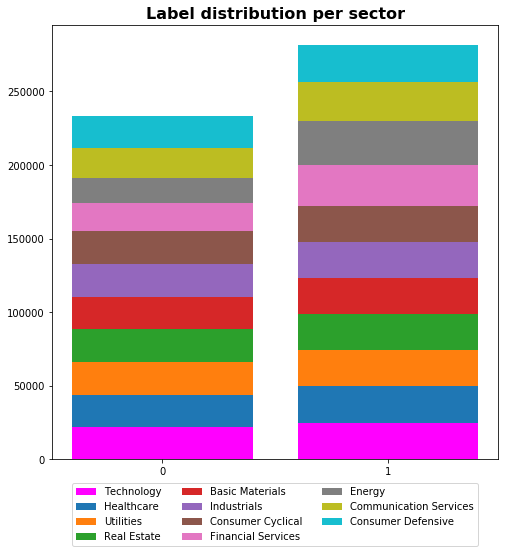

In [21]:
colors = ['tab:blue',
          'tab:orange',
          'tab:green',
          'tab:red',
          'tab:purple',
          'tab:brown',
          'tab:pink',
          'tab:gray',
          'tab:olive',
          'tab:cyan',
          'lime',
          'magenta']

fig,ax = plt.subplots(figsize=(8,8))
y_offset = np.zeros(y[0].unique().shape[0])#0

# Unique Sectors
uniqueSectors = X.sector.unique() 

# Empty list to hold data
data_ls = []

for i,us in enumerate(uniqueSectors):
    
    t, c = np.unique(y[X.sector==us],return_counts = True)
    
    ax.bar(t,c,
           color = colors[i-1],
           bottom = y_offset,label=us)
    
    y_offset = y_offset + c

plt.legend(loc='lower center',
#            mode='expand',
           ncol=3,
           bbox_to_anchor = (0.5,-0.21),
          )#(1,0,0,0)
plt.title('Label distribution per sector',fontweight='bold',fontsize=16)
plt.xticks(t)
plt.show()

In [22]:
uniqueSectors = X.sector.unique() 
for i,us in enumerate(uniqueSectors):
#     print(y[X.sector==us])
    t, c = np.unique(y[X.sector==us],return_counts = True)
    
    if i == 0:
        print(t,'\n\n',us,': ',c,'\n',(c/sum(c)).round(3))
    else:
        print(us,': ',c,'\n',(c/sum(c)).round(3),'\n')
    

[0. 1.] 

 Technology :  [21979 24809] 
 [0.47 0.53]
Healthcare :  [21590 25198] 
 [0.461 0.539] 

Utilities :  [22573 24215] 
 [0.482 0.518] 

Real Estate :  [22434 24354] 
 [0.479 0.521] 

Basic Materials :  [21840 24948] 
 [0.467 0.533] 

Industrials :  [22584 24204] 
 [0.483 0.517] 

Consumer Cyclical :  [22193 24595] 
 [0.474 0.526] 

Financial Services :  [18875 27913] 
 [0.403 0.597] 

Energy :  [17458 29330] 
 [0.373 0.627] 

Communication Services :  [19798 26990] 
 [0.423 0.577] 

Consumer Defensive :  [22023 24765] 
 [0.471 0.529] 



In [24]:
def extract_labels_multi(data = None, classes = 5, group_style = 'equal'):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
    returns = ((data[1:] / data[:-1]) -1) * 100

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        thresholdsMin = [np.array_split(np.sort(returns), classes)[i].min() for i in np.arange(classes)]
        thresholdsMax = [np.array_split(np.sort(returns), classes)[i].max() for i in np.arange(classes)]
    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    for i in np.arange(classes):
        if i == 0:
            labels[(returns <= thresholdsMax[i])] = i

        elif i == (classes-1):
            labels[(returns >= thresholdsMin[i])] = i

        else:
            labels[(returns >= thresholdsMin[i]) & (returns<=thresholdsMax[i])] = i

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [25]:
data

open     high      low    close  spread_open  spread_high  \
20200501 0    286.250  289.260  285.870  289.260         0.50         0.50   
         1    289.260  289.350  288.365  289.020         0.24         0.45   
         2    289.035  289.705  288.280  288.580         0.07         0.49   
         3    288.485  289.315  288.280  289.095         0.49         0.49   
         4    289.100  290.435  288.940  290.320         0.16         0.33   
...               ...      ...      ...      ...          ...          ...   
20200529 385  123.950  124.110  123.910  124.100         0.02         0.07   
         386  124.085  124.085  123.920  123.995         0.01         0.06   
         387  123.995  124.355  123.985  124.335         0.01         0.07   
         388  124.335  124.355  124.060  124.075         0.05         0.12   
         389  124.075  124.225  122.810  123.855         0.01         2.43   

              spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0          0.01          0.24           6.0          95.0   
         1          0.01          0.10           9.0          20.0   
         2          0.01          0.30           1.0          50.0   
         3          0.01          0.17           1.0          25.0   
         4          0.01          0.10          13.0          71.0   
...                  ...           ...           ...           ...   
20200529 385        0.01          0.04           1.0          11.0   
         386        0.01          0.01           1.0           8.0   
         387        0.01          0.05           4.0          16.0   
         388        0.01          0.01           3.0           6.0   
         389        0.01          0.21           1.0          20.0   

              bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0            1.0           10.0           1.0          85.0   
         1            1.0            1.0           4.0          56.0   
         2            1.0            1.0           1.0          13.0   
         3            1.0           16.0           1.0           8.0   
         4            1.0            1.0           1.0         236.0   
...                   ...            ...           ...           ...   
20200529 385          1.0            1.0           5.0           9.0   
         386          1.0            3.0           1.0           9.0   
         387          1.0            2.0           2.0          10.0   
         388          1.0            2.0           2.0          10.0   
         389          1.0            2.0           4.0          12.0   

              ofrsize_low  ofrsize_close Ticker  
20200501 0            1.0            4.0   AAPL  
         1            1.0            1.0   AAPL  
         2            1.0            1.0   AAPL  
         3            1.0            1.0   AAPL  
         4            1.0            1.0   AAPL  
...                   ...            ...    ...  
20200529 385          1.0            1.0    WMT  
         386          1.0            2.0    WMT  
         387          1.0            2.0    WMT  
         388          1.0            4.0    WMT  
         389          1.0            1.0    WMT  

[514800 rows x 17 columns]

In [26]:
price_candles[price_candles.Ticker=='AAPL']

open     high      low    close Ticker
20200501 0    286.250  289.260  285.870  289.260   AAPL
         1    289.260  289.350  288.365  289.020   AAPL
         2    289.035  289.705  288.280  288.580   AAPL
         3    288.485  289.315  288.280  289.095   AAPL
         4    289.100  290.435  288.940  290.320   AAPL
...               ...      ...      ...      ...    ...
20200529 385  319.255  319.415  318.830  319.095   AAPL
         386  319.095  319.295  318.810  318.845   AAPL
         387  318.845  319.605  318.695  319.460   AAPL
         388  319.465  319.555  318.660  318.675   AAPL
         389  318.675  319.380  317.500  317.920   AAPL

[7800 rows x 5 columns]

In [27]:
price_candles[price_candles.Ticker=='AAPL']['close'].values

array([289.26 , 289.02 , 288.58 , ..., 319.46 , 318.675, 317.92 ])

In [28]:
extract_labels_multi(price_candles[price_candles.Ticker=='AAPL']['close'].values,classes = 4)

array([0., 0., 3., ..., 3., 0., 0.])

In [29]:
np.unique(extract_labels_multi(price_candles[price_candles.Ticker=='AAPL']['close'].values,classes = 4),return_counts=True)

(array([0., 1., 2., 3.]), array([1950, 1950, 1950, 1949], dtype=int64))

## Investigating across all tickers

In [30]:
for ut in uniqueTickers:
#     print(price_candles[price_candles.Ticker==us].shape)
    t,c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ut]['close'].values,
                                         classes = 4),
                    return_counts=True)
    
    print(ut,': ',c)

AAPL :  [1950 1950 1950 1949]
ABBV :  [1950 1746 2154 1949]
ABT :  [1950 1761 2139 1949]
AEP :  [1950 1890 2010 1949]
AMT :  [1950 1858 2042 1949]
APD :  [1950 1870 2030 1949]
BA :  [1950 1872 2028 1949]
BABA :  [1950 1899 2001 1949]
BAC :  [1949 1100 2796 1954]
BHP :  [1950 1308 2592 1949]
BP :  [1947 1020 2882 1950]
CCI :  [1950 1849 2051 1949]
CHL :  [1949 1001 2898 1951]
COST :  [1950 1860 2040 1949]
CSGP :  [1950 1617 2283 1949]
D :  [1950 1817 2083 1949]
DIS :  [1950 1796 2104 1949]
ECL :  [1950 1950 1950 1949]
ENB :  [1950 1258 2638 1953]
EXC :  [1950 1492 2408 1949]
FB :  [1950 1950 1950 1949]
FMX :  [1950 1615 2285 1949]
GOOG :  [1950 1950 1950 1949]
IDU :  [1950 1949 1951 1949]
INTC :  [1949 1577 2324 1949]
IYC :  [1950 1798 2102 1949]
IYE :  [1946 1099 2805 1949]
IYG :  [1950 1766 2134 1949]
IYH :  [1950 1800 2100 1949]
IYJ :  [1950 1708 2192 1949]
IYK :  [1949 1736 2165 1949]
IYM :  [1950 1712 2188 1949]
IYR :  [1950 1663 2236 1950]
IYW :  [1950 1950 1950 1949]
IYZ :  [1943

In [120]:
np.sort(returns)

array([-0.98475044, -0.75034838, -0.71846282, ...,  1.35613928,
        2.76560633,  2.79889807])

In [121]:
np.array_split(np.sort(returns), 4)

[array([-0.98475044, -0.75034838, -0.71846282, ..., -0.0486766 ,
        -0.04861449, -0.04859611]),
 array([-0.04859349, -0.04858562, -0.048583  , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.04930696, 0.04942339,
        0.04943425]),
 array([0.04943968, 0.0494424 , 0.04944512, ..., 1.35613928, 2.76560633,
        2.79889807])]

In [122]:
classes

2268

In [153]:
print(np.array_split(np.sort(returns), classes)[0],'\n\n',
        np.array_split(np.sort(returns), classes)[0].min(),'\n',
        np.array_split(np.sort(returns), classes)[0].max())

[-0.98475044 -0.75034838 -0.71846282 ... -0.0486766  -0.04861449
 -0.04859611] 

 -0.9847504361037651 
 -0.04859611231100569


In [163]:
subData = price_candles[price_candles.Ticker=='ABBV']['close'].values
classes = 4

returns = ((subData[1:] / subData[:-1]) -1) * 100

labels = np.zeros(returns.shape[0])

# print([np.array_split(np.sort(returns), classes)[i] for i in np.arange(classes)])

thresholdsMin = [np.array_split(np.sort(returns), classes)[i].min() for i in np.arange(classes)]
thresholdsMax = [np.array_split(np.sort(returns), classes)[i].max() for i in np.arange(classes)]

print(thresholdsMin,'\n',thresholdsMax)

for i in np.arange(classes):
    if i == 0:
        labels[(returns <= thresholdsMax[i])] = i

    elif i == (classes-1):
        labels[(returns > thresholdsMin[i])] = i

    else:
        labels[(returns > thresholdsMin[i]) & (returns <= thresholdsMax[i])] = i


[-0.9847504361037651, -0.048593488472548074, 0.0, 0.04943968358601669] 
 [-0.04859611231100569, 0.0, 0.04943425244425814, 2.798898071625344]


In [164]:
labels

array([3., 0., 3., ..., 0., 3., 0.])

In [165]:
np.unique(labels,return_counts=True)

(array([0., 1., 2., 3.]), array([1952, 2020, 1879, 1948], dtype=int64))

In [166]:
returns[labels==0]

array([-0.58096869, -0.05518764, -0.27514522, ..., -0.08719821,
       -0.07004688, -0.16155959])

In [147]:
sum(returns==0)

275

In [168]:
print(returns[(returns< thresholdsMin[1])&(returns< thresholdsMax[1])],'\n\n',
      returns[(returns< thresholdsMin[1])&(returns< thresholdsMax[1])].shape)

[-0.58096869 -0.05518764 -0.27514522 ... -0.08719821 -0.07004688
 -0.16155959] 

 (1950,)


In [203]:
# which = 2
# print('Min: ',thresholdsMin[which],'\n',
#       'Max: ',thresholdsMax[which],'\n\n',
#       returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])],'\n',
#       np.sort(returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]).round(6),'\n\n',
# #       returns[(returns> )&(returns<= thresholdsMax[which])],'\n\n',
#       returns[(returns> thresholdsMin[which])&(returns<= thresholdsMax[which])].shape)
which = 1
# tempSeries = returns[(returns > 0.0)&(returns<= thresholdsMax[which])]
# tempSeries = returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]
tempSeries = returns[(returns > thresholdsMin[which])&(returns<= -0.0000001)]
print('Min: ',thresholdsMin[which],'\n',
      'Max: ',thresholdsMax[which],'\n\n',
      tempSeries,'\n',
      np.sort(tempSeries).round(10),'\n\n',
#       returns[(returns> )&(returns<= thresholdsMax[which])],'\n\n',
      tempSeries.shape)

Min:  -0.048593488472548074 
 Max:  0.0 

 [-0.01224965 -0.03673769 -0.02440215 ... -0.0218627  -0.00545762
 -0.016254  ] 
 [-0.04858562 -0.048583   -0.04855678 ... -0.00537981 -0.0053582
 -0.00535275] 

 (1738,)


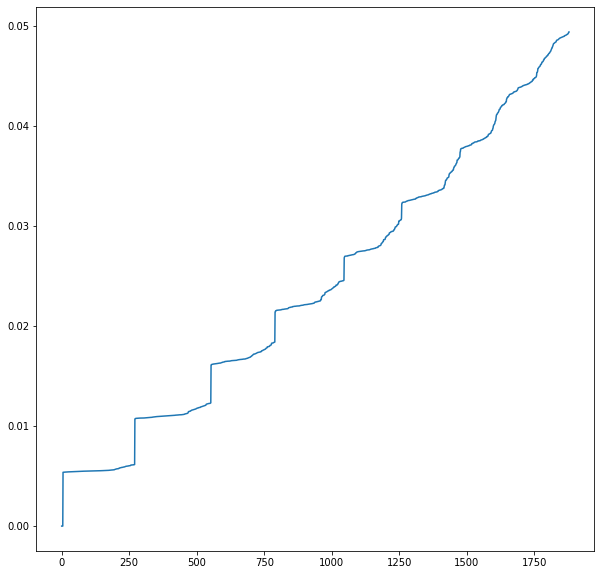

In [190]:
plt.figure(figsize=(10,10))
plt.plot(np.sort(returns[(returns > thresholdsMin[which])&(returns<= thresholdsMax[which])]))
plt.show()

In [207]:
class0 = np.array_split(np.sort(returns),4)[0]
class1 = np.array_split(np.sort(returns),4)[1]
class2 = np.array_split(np.sort(returns),4)[2]
class3 = np.array_split(np.sort(returns),4)[3]

# [np.array_split(np.sort(returns),4)[i].shape for i in np.arange(4)]

In [215]:
np.isin(returns,class3)

array([ True, False,  True, ..., False,  True, False])

In [223]:
np.random.normal(0,1)/1000000

6.402904043842307e-07

In [246]:
subData = price_candles[price_candles.Ticker=='ABBV']['close'].values
classes = 4

returns = ((subData[1:] / subData[:-1]) -1) * 100
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000
labels_1 = np.zeros(returns.shape[0])

# print([np.array_split(np.sort(returns), classes)[i] for i in np.arange(classes)])

# thresholdsMin = [np.array_split(np.sort(returns), classes)[i].min() for i in np.arange(classes)]
# thresholdsMax = [np.array_split(np.sort(returns), classes)[i].max() for i in np.arange(classes)]

splits = np.array_split(np.sort(returns),4)

# print(thresholdsMin,'\n',thresholdsMax)

for i in np.arange(classes):
    print(splits[i].shape)
    #     if i == 0:
#         labels[(returns <= thresholdsMax[i])] = i

#     elif i == (classes-1):
#         labels[(returns > thresholdsMin[i])] = i

#     else:
#         labels[(returns > thresholdsMin[i]) & (returns <= thresholdsMax[i])] = i
    labels_1[np.isin(returns,splits[i])] = i


(1950,)
(1950,)
(1950,)
(1949,)


In [247]:
np.unique(labels_1,return_counts=True)

(array([0., 1., 2., 3.]), array([1950, 1950, 1950, 1949], dtype=int64))

In [226]:
returns[returns==0]

array([], dtype=float64)

In [241]:
np.random.normal(0,1,sum(returns==0))/100000

array([-9.40904681e-07,  9.15898926e-06,  7.65129312e-06,  1.53871636e-05,
        7.81663533e-06,  1.11229918e-06,  1.61803359e-05,  2.58548514e-06,
       -2.70466233e-06, -3.61493823e-06, -3.19051319e-06,  3.89439626e-06,
       -1.24871888e-05,  3.80702077e-06, -3.17358242e-06,  5.31251041e-06,
        7.88258454e-06, -1.56041682e-05,  2.44436889e-05,  3.37275605e-06,
       -1.39533175e-05, -8.68422835e-07,  6.51059414e-06, -7.94187134e-07,
       -1.41864340e-05,  1.55609623e-05, -3.59696774e-06,  8.96766295e-07,
        6.05238666e-07, -4.34936858e-06, -2.81680595e-06, -1.28537763e-05,
       -4.19550002e-06,  2.63312392e-05, -5.19619830e-06,  1.64064893e-05,
        3.87038719e-06,  1.08567236e-05, -4.44385421e-06,  2.28757065e-05,
        5.33042728e-06,  1.81093151e-06, -3.01174787e-06,  8.19713187e-06,
        7.58688571e-06, -6.15794845e-06, -6.69504743e-06,  2.85066480e-05,
        9.29231502e-07,  1.18933686e-05, -5.82187038e-06,  4.39108645e-06,
        1.75051352e-05,  

In [237]:
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000

In [ ]:
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
    returns = ((data[1:] / data[:-1]) -1) * 100
    # If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        if splits is None:
            splits = np.array_split(np.sort(returns),classes)

        for i in np.arange(classes):

            labels[np.isin(returns,splits[i])] = i

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [61]:
data

array([289.26 , 289.02 , 288.58 , ..., 124.335, 124.075, 123.855])

In [62]:
returns = np.concatenate([((price_candles[price_candles.Ticker==ticker]['close'].values[1:]/\
                         price_candles[price_candles.Ticker==ticker]['close'].values[:-1])-1) for ticker\
                          in price_candles.Ticker.unique()])

In [63]:
returns.shape

(514734,)

In [24]:
data = price_candles['close'].values#[price_candles.Ticker=='ABBV']

In [25]:
data.shape

(514800,)

In [69]:
# returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
# returns = ((data[1:] / data[:-1]) -1) * 100
# returns = ((data[1:] / data[:-1]) -1) * 100
# If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000
classes = 2
labels = np.zeros(returns.shape[0])

# if group_style == 'equal':
#     if splits is None:
splits = np.array_split(np.sort(returns),classes)

for i in np.arange(classes):

    labels[np.isin(returns,splits[i])] = i

# elif group_style != 'equal':
#     raise ValueError(f'group_style {group_style} not implemented')

#     return labels #, returns, [thresholdsMin, thresholdsMax]

In [65]:
labels.shape

(514734,)

In [66]:
splits[0].shape

(257367,)

In [67]:
splits[1].shape

(257367,)

In [70]:
np.unique(labels,return_counts=True)

(array([0., 1.]), array([257367, 257367], dtype=int64))

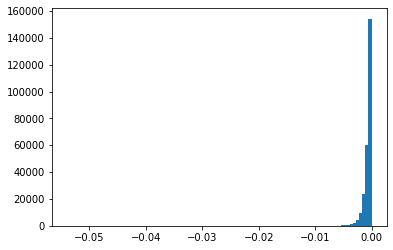

In [71]:
plt.hist(splits[0],bins=100)
plt.show()

In [72]:
splits[0].min(),splits[1].min(),splits[0].max(),splits[1].max()

(-0.053926348158703896,
 1.9029269130544944e-08,
 1.899349586016317e-08,
 0.0907158043940468)

In [73]:
returns.min(),returns.max()

(-0.053926348158703896, 0.0907158043940468)

In [34]:
def extract_labels_multi(data = None,
                        classes = 5,
                        group_style = 'equal',
                        splits=None):

   # returns = ((data.T[-1][1:]/data.T[-1][0:-1])-1)*100
    returns = ((data[1:] / data[:-1]) -1) * 100
    # If returns are exact zero, perhaps because there hasn't been any price updates over a candle, we add a little bit of noise, to ensure that the labels are evenly distributed.
    returns[returns==0] = np.random.normal(0,1,sum(returns==0))/1000000

    labels = np.zeros(returns.shape[0])

    if group_style == 'equal':
        if splits is None:
            splits = np.array_split(np.sort(returns),classes)

        for i in np.arange(classes):

            labels[np.isin(returns,splits[i])] = i

    elif group_style != 'equal':
        raise ValueError(f'group_style {group_style} not implemented')

    return labels #, returns, [thresholdsMin, thresholdsMax]

In [35]:
X.columns

Index(['open_lag0', 'high_lag0', 'low_lag0', 'close_lag0', 'spread_open_lag0',
       'spread_high_lag0', 'spread_low_lag0', 'spread_close_lag0',
       'bidsize_open_lag0', 'bidsize_high_lag0', 'bidsize_low_lag0',
       'bidsize_close_lag0', 'ofrsize_open_lag0', 'ofrsize_high_lag0',
       'ofrsize_low_lag0', 'ofrsize_close_lag0', 'open_lag1', 'high_lag1',
       'low_lag1', 'close_lag1', 'spread_open_lag1', 'spread_high_lag1',
       'spread_low_lag1', 'spread_close_lag1', 'bidsize_open_lag1',
       'bidsize_high_lag1', 'bidsize_low_lag1', 'bidsize_close_lag1',
       'ofrsize_open_lag1', 'ofrsize_high_lag1', 'ofrsize_low_lag1',
       'ofrsize_close_lag1', 'ticker', 'sector'],
      dtype='object')

In [40]:
sum_0 = 0
sum_1 = 0
for ticker in X.ticker.unique():
#     temp = price_candles[price_candles.Ticker==ticker]['close'].values#
    t, c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ticker]['close'].values,
                         2,
                         'equal',
                         splits),return_counts=True)
    print(t,c)
    sum_0 += c[0]
    sum_1 += c[1]

[0. 1.] [3880 3919]
[0. 1.] [3988 3811]
[0. 1.] [4040 3759]
[0. 1.] [4108 3691]
[0. 1.] [3948 3851]
[0. 1.] [4037 3762]
[0. 1.] [3934 3865]
[0. 1.] [4005 3794]
[0. 1.] [4755 3044]
[0. 1.] [4513 3286]
[0. 1.] [4968 2831]
[0. 1.] [3951 3848]
[0. 1.] [4974 2825]
[0. 1.] [3955 3844]
[0. 1.] [4173 3626]
[0. 1.] [4075 3724]
[0. 1.] [3942 3857]
[0. 1.] [3874 3925]
[0. 1.] [4573 3226]
[0. 1.] [4394 3405]
[0. 1.] [3862 3937]
[0. 1.] [4324 3475]
[0. 1.] [3816 3983]
[0. 1.] [4100 3699]
[0. 1.] [4256 3543]
[0. 1.] [3952 3847]
[0. 1.] [4828 2971]
[0. 1.] [3974 3825]
[0. 1.] [3968 3831]
[0. 1.] [3964 3835]
[0. 1.] [4121 3678]
[0. 1.] [4039 3760]
[0. 1.] [4188 3611]
[0. 1.] [3831 3968]
[0. 1.] [5160 2639]
[0. 1.] [4085 3714]
[0. 1.] [4569 3230]
[0. 1.] [7070  729]
[0. 1.] [3965 3834]
[0. 1.] [3958 3841]
[0. 1.] [3919 3880]
[0. 1.] [4000 3799]
[0. 1.] [3928 3871]
[0. 1.] [4002 3797]
[0. 1.] [3909 3890]
[0. 1.] [4202 3597]
[0. 1.] [5803 1996]
[0. 1.] [4073 3726]
[0. 1.] [4841 2958]
[0. 1.] [4070 3729]


In [41]:
sum_0,sum_1

(280922, 233812)

In [44]:
returns.shape

(514799,)

In [58]:
global_median = np.median(returns)

In [59]:
global_median

0.0

In [ ]:
sum_0 = 0
sum_1 = 0
for ticker in X.ticker.unique():
#     temp = price_candles[price_candles.Ticker==ticker]['close'].values#
    t, c = np.unique(extract_labels_multi(price_candles[price_candles.Ticker==ticker]['close'].values,
                         2,
                         'equal',
                         splits),return_counts=True)
    print(t,c)
    sum_0 += c[0]
    sum_1 += c[1]

## Investigating the distribution of the first differenced prices.

In [51]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,bidsize_open_lag1,bidsize_high_lag1,bidsize_low_lag1,bidsize_close_lag1,ofrsize_open_lag1,ofrsize_high_lag1,ofrsize_low_lag1,ofrsize_close_lag1,ticker,sector
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,6.0,95.0,1.0,10.0,1.0,85.0,1.0,4.0,AAPL,Technology
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,9.0,20.0,1.0,1.0,4.0,56.0,1.0,1.0,AAPL,Technology
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,1.0,50.0,1.0,1.0,1.0,13.0,1.0,1.0,AAPL,Technology
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,1.0,25.0,1.0,16.0,1.0,8.0,1.0,1.0,AAPL,Technology
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,13.0,71.0,1.0,1.0,1.0,236.0,1.0,1.0,AAPL,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514663,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,1.0,9.0,1.0,1.0,2.0,8.0,1.0,7.0,WMT,Consumer Defensive
514664,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,3.0,6.0,1.0,1.0,7.0,8.0,1.0,4.0,WMT,Consumer Defensive
514665,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,1.0,11.0,1.0,1.0,5.0,9.0,1.0,1.0,WMT,Consumer Defensive
514666,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,1.0,8.0,1.0,3.0,1.0,9.0,1.0,2.0,WMT,Consumer Defensive


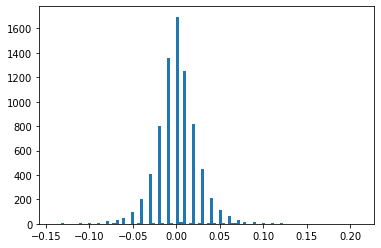

In [62]:
plt.hist(X[X.ticker=='BAC']['open_lag0'],bins=100)
plt.show()

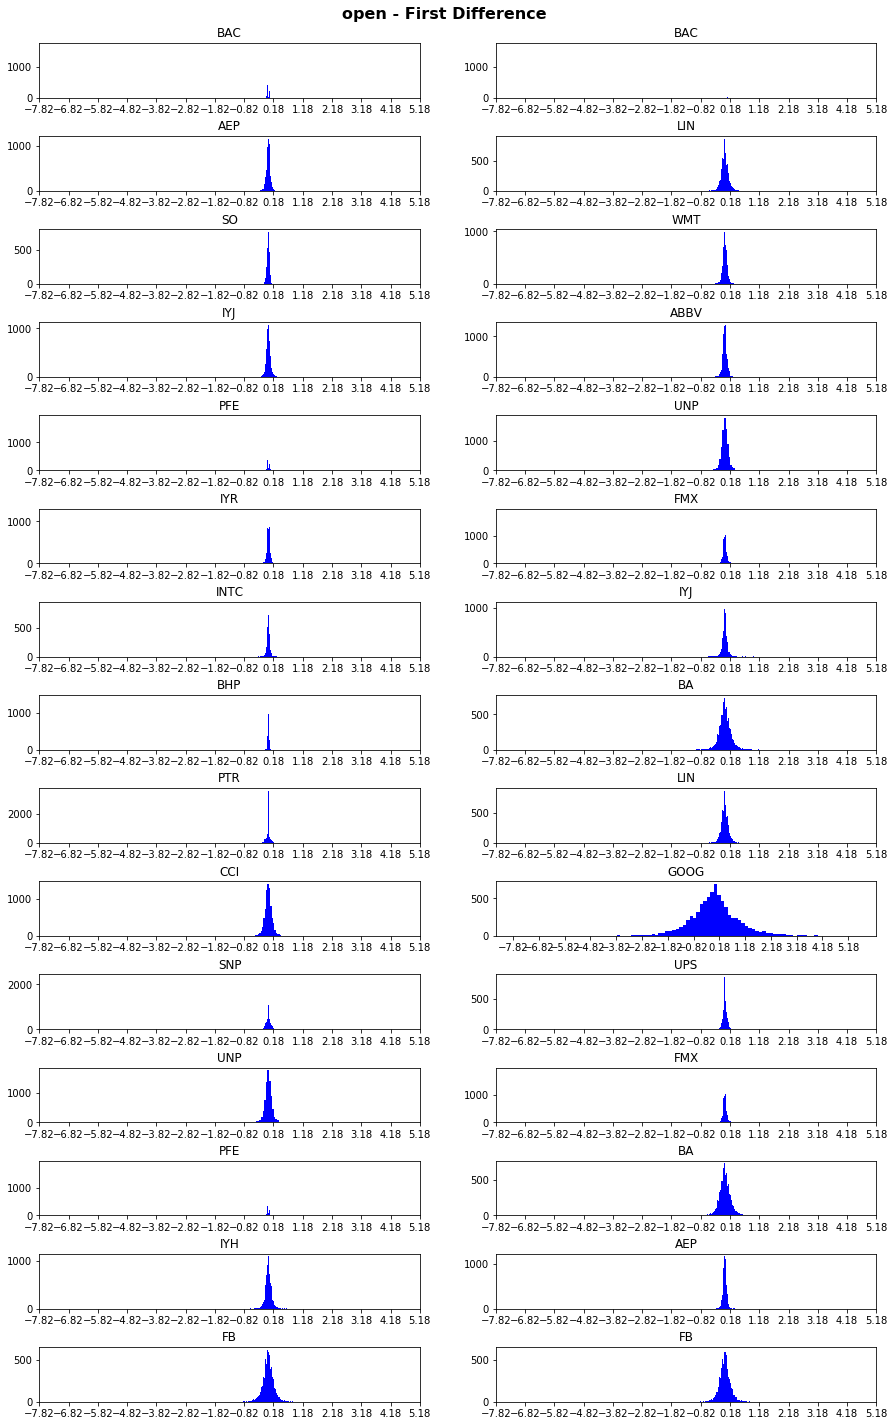

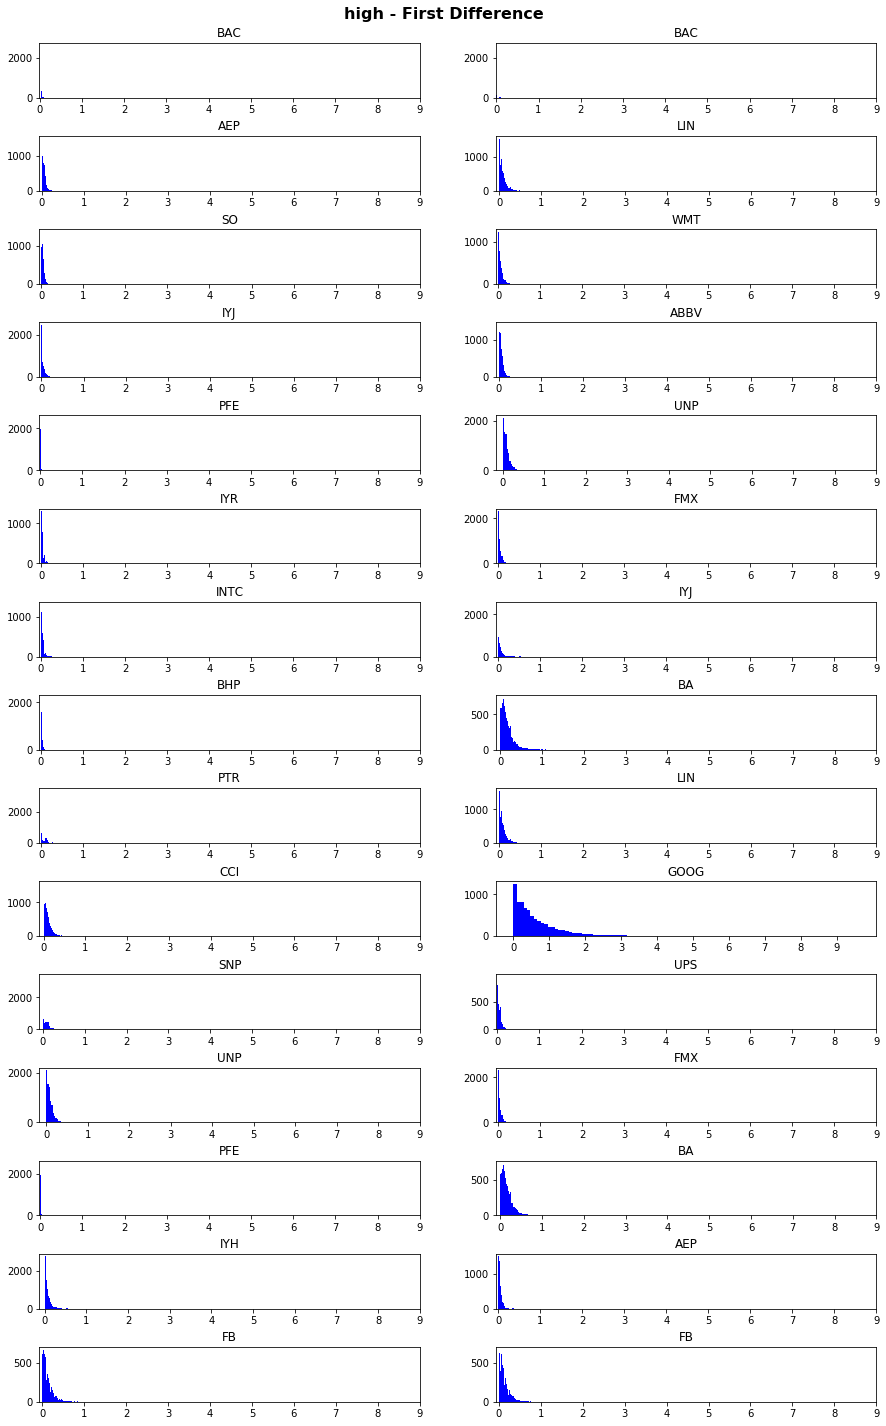

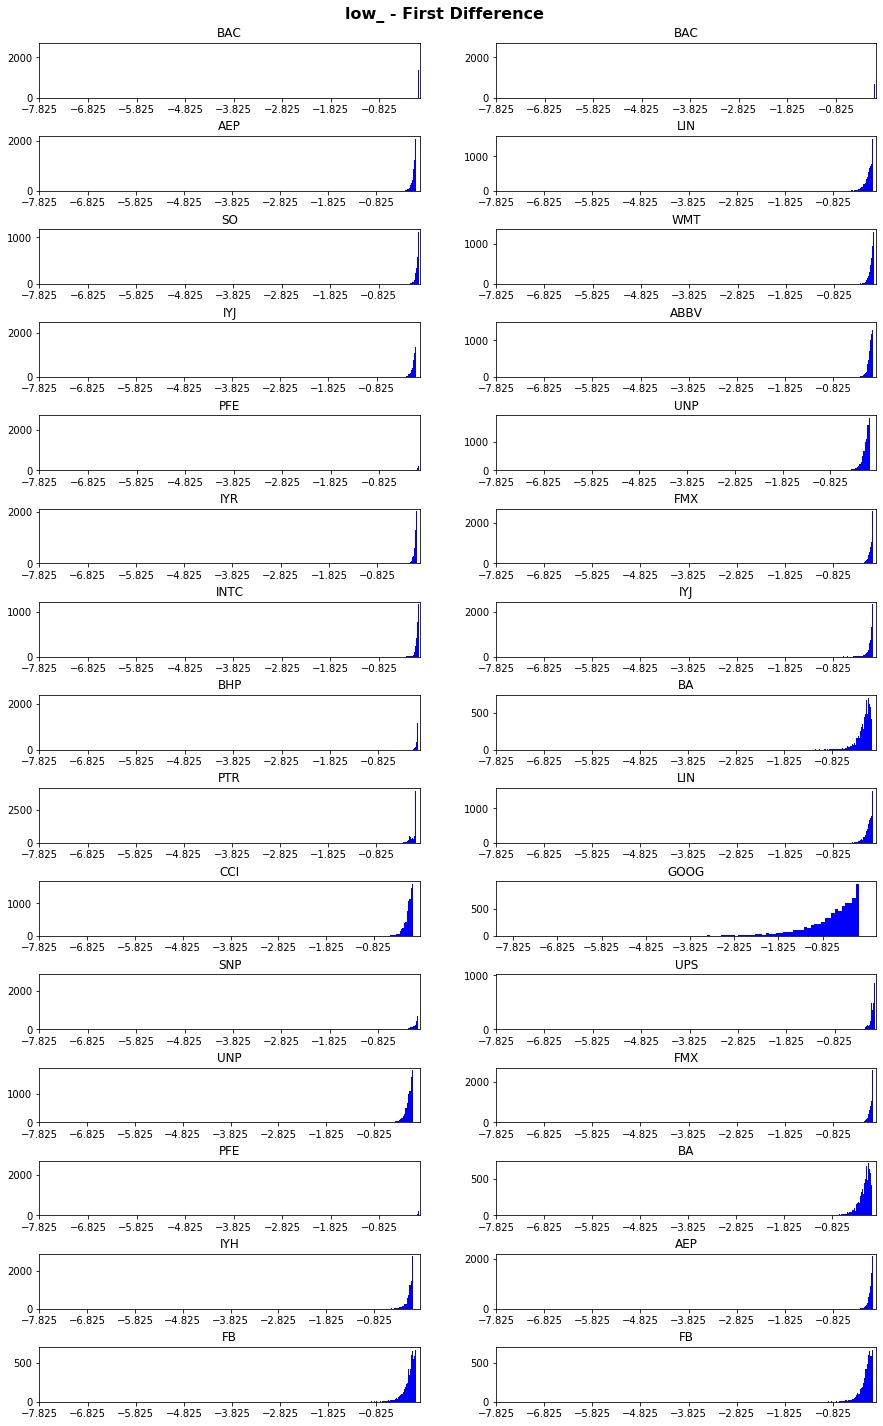

In [58]:
#### Choose random tickers, and check their relative distribution of the first differenced prices

# NB: For now, only 11 tickers can be chosen if one wants individual colors on the plots below 
numberOfTickersToPlot = 30

## Set seed
np.random.seed(2020)

# Choose the tickers randomly
randomlyChosenTickers = np.random.randint(0
                                          ,X.ticker.unique().shape[0]
                                          ,numberOfTickersToPlot)
randomTickers = uniqueTickers[randomlyChosenTickers]

# Variables to plot
variablesToPlot = ['open_lag0','high_lag0','low_lag0']

# Setting the plot size globally.
plotSize = (15,2)

for var in variablesToPlot:

# print(randomlyChosenTickers,randomTickers)

    fig,ax = plt.subplots(plotSize[0],
                          plotSize[1],
                          figsize=(15,25))

    bounds = [X[X.ticker.isin(randomTickers)][var].min(),
              X[X.ticker.isin(randomTickers)][var].max()]

    helper = 0
    for j in np.arange(plotSize[1]):

        for jj in np.arange(plotSize[0]):

    #         ax[j,jj].hist(X.iloc[:,order[j,jj]]
    #                       ,bins = 100)
    #         print(randomTickers[helper+jj],helper+jj)
            if numberOfTickersToPlot <= 11:
            
                ax[jj,j].hist(X[X.ticker==randomTickers[helper+jj]][var],
                                bins=100,
                                color = colors[helper+jj])
            else:
                
                ax[jj,j].hist(X[X.ticker==randomTickers[helper+jj]][var],
                            bins=100,
                            color = 'b')

            ax[jj,j].set_title(randomTickers[helper+jj])
            ax[jj,j].set_xticks(np.arange(bounds[0],bounds[1]))
        helper += plotSize[0]

    plt.subplots_adjust(hspace=0.7)
    fig.suptitle(var[0:4]+' - First Difference',
                 fontweight='bold',
                 fontsize= 16,
                 y=0.9)
    plt.show()

# plt.show()

## Continuing with models.

In [31]:
## Adding ticker dummies
tickers = X.pop('ticker')
X = pd.concat([X, pd.get_dummies(tickers, prefix='ticker', drop_first=False)], axis=1)

## Adding Sector dummies
tickers = X.pop('sector')
X = pd.concat([X, pd.get_dummies(tickers, prefix='sector', drop_first=False)], axis=1)

In [32]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Real Estate,sector_Technology,sector_Utilities
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,0,1,0
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,0,0,0,0,0,0,0,0,1,0
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,0,0,0,0,0,0,0,0,1,0
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,0,0,0,0,0,0,0,0,1,0
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514663,-0.110,0.010,-0.175,123.950,0.02,0.07,0.01,0.02,3.0,6.0,...,0,0,1,0,0,0,0,0,0,0
514664,-0.150,0.010,-0.190,124.100,0.02,0.07,0.01,0.04,1.0,11.0,...,0,0,1,0,0,0,0,0,0,0
514665,0.090,0.090,-0.075,123.995,0.01,0.06,0.01,0.01,1.0,8.0,...,0,0,1,0,0,0,0,0,0,0
514666,-0.340,0.020,-0.350,124.335,0.01,0.07,0.01,0.05,4.0,16.0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
y

,0
0,0.0
1,1.0
2,1.0
3,0.0
4,1.0
...,...
514663,1.0
514664,0.0
514665,1.0
514666,0.0


In [34]:
X.head()

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,sector_Communication Services,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Energy,sector_Financial Services,sector_Healthcare,sector_Industrials,sector_Real Estate,sector_Technology,sector_Utilities
0,0.240,0.330,-0.655,289.020,0.24,0.45,0.01,0.10,9.0,20.0,...,0,0,0,0,0,0,0,0,1,0
1,0.455,1.125,-0.300,288.580,0.07,0.49,0.01,0.30,1.0,50.0,...,0,0,0,0,0,0,0,0,1,0
2,-0.610,0.220,-0.815,289.095,0.49,0.49,0.01,0.17,1.0,25.0,...,0,0,0,0,0,0,0,0,1,0
3,-1.220,0.115,-1.380,290.320,0.16,0.33,0.01,0.10,13.0,71.0,...,0,0,0,0,0,0,0,0,1,0
4,0.235,0.355,-0.565,290.085,0.10,0.42,0.01,0.05,2.0,86.0,...,0,0,0,0,0,0,0,0,1,0


# Train a few models

In [35]:
'''
We need:

validate_ds = val_data.cache()
train_ds = train_data.cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)


'''

'\nWe need:\n\nvalidate_ds = val_data.cache()\ntrain_ds = train_data.cache()\n\nvalidate_ds = validate_ds.batch(BATCH_SIZE)\ntrain_ds = train_ds.batch(BATCH_SIZE)\n\n\n'

In [36]:
val_cutoff = int(X.shape[0]*0.8)
train_ds, train_y = X.iloc[:val_cutoff, :], y[:val_cutoff]
validate_ds, val_y = X.iloc[val_cutoff:, :], y[val_cutoff:]


In [37]:
N_VALIDATION = y[val_cutoff:].shape[0] #int(1e3)
N_TRAIN = y[:val_cutoff].shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = X.shape[1]

N_TRAIN, N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(411734, 102934, 1608, 131, 804000)

In [38]:
train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape

((411734, 109), (411734, 1), (102934, 109), (102934, 1))

In [ ]:
train_ds_tf = tf.data.Dataset.from_tensor_slices((X.iloc[:val_cutoff, :].values, y[:val_cutoff]))\
                                .cache()\
                                .repeat(N_REPEAT)\
                                .batch(BATCH_SIZE)
train_ds_tf

In [39]:
X.iloc[:val_cutoff, :].values[0]

array([ 2.4000e-01,  3.3000e-01, -6.5500e-01,  2.8902e+02,  2.4000e-01,
        4.5000e-01,  1.0000e-02,  1.0000e-01,  9.0000e+00,  2.0000e+01,
        1.0000e+00,  1.0000e+00,  4.0000e+00,  5.6000e+01,  1.0000e+00,
        1.0000e+00, -2.7700e+00,  2.4000e-01, -3.1500e+00,  2.4000e-01,
        5.0000e-01,  5.0000e-01,  1.0000e-02,  2.4000e-01,  6.0000e+00,
        9.5000e+01,  1.0000e+00,  1.0000e+01,  1.0000e+00,  8.5000e+01,
        1.0000e+00,  4.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.00

In [299]:
# for feat, targ in train_ds_tf.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [77]:
validate_ds_tf = tf.data.Dataset.from_tensor_slices((X.iloc[val_cutoff:, :].values, 
                                                  y[val_cutoff:]))\
                                                    .cache().repeat(N_REPEAT).batch(BATCH_SIZE)

In [28]:
validate_ds_tf

NameError: name 'validate_ds_tf' is not defined

In [300]:
# for feat, targ in validate_ds_tf.take(2):
#   print ('Features: {}, Target: {}'.format(feat, targ))

# Begin with some sklearn logistic regression in a gridsearch

In [86]:
# Adding a few things
from sklearn.linear_model import LogisticRegression

## Setting up the model and corresponding parameters

logreg = LogisticRegression(random_state=123, max_iter=100, multi_class='auto')
#rf = ensemble.RandomForestClassifier()

param_grid = {'logreg': {'penalty': ['l2','none'], # some solvers do not accept l1
                         'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
                         'fit_intercept': [False, True],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
                         #'multi_class': ['ovr', 'multinomial']
                        },
              'knn': {'n_neighbors': [1,3,5,7,9,11,13,15,17,19]},
              'rf': {'n_estimators': [50,100,200], 'max_features': ['auto', None], 'min_samples_leaf': [1, 5, 10]}}

## Setting parameters for grid search
cv_folds = 5
n_jobs = 10
typesOfCV = {'Standard':cv_folds,
             #'Time Series Splitting':TimeSeriesSplit(cv_folds),
             #'Blocked Time Series Splitting':BlockingTimeSeriesSplit(cv_folds)
            }

# Perform different types of grid search.
for cvType,container in typesOfCV.items():
    print('---------------- Evaluating %s ----------------' % cvType)
    start = time.time()
    
    ## Performing grid search
    #grid_search = GridSearchCV(rf, param_grid['rf'], cv = container, n_jobs = n_jobs)# cv = cv_folds
    grid_search = GridSearchCV(logreg, param_grid['logreg'], cv = container, n_jobs = n_jobs, verbose=1)# cv = cv_folds
    grid_search.fit(train_ds, train_y.values.ravel())

    # store the best hyperparameters and best CV performance
    logreg_params = grid_search.best_params_
    logreg_cv_res = grid_search.cv_results_

---------------- Evaluating Standard ----------------
Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


KeyboardInterrupt: 

In [84]:
grid_search.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [82]:
logreg_params

NameError: name 'logreg_params' is not defined

# Setup logistic in TF/keras and add a params tuner

In [30]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# def make_model(metrics = METRICS, output_bias=None):
#   if output_bias is not None:
#     output_bias = tf.keras.initializers.Constant(output_bias)
#   model = keras.Sequential([
#       keras.layers.Dense(
#           16, activation='relu',
#           input_shape=(train_features.shape[-1],)),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(1, activation='sigmoid',
#                          bias_initializer=output_bias),
#   ])

#   model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
#       loss=keras.losses.BinaryCrossentropy(),
#       metrics=metrics)

#   return model

# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,))
# })

model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(1,
                       input_shape=(FEATURES,),
                       activation='sigmoid',
                       kernel_regularizer=regularizers.l2(1))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
model.compile(
              optimizer=keras.optimizers.Adam(), #lr=1e-3
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_auc', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 396       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


ValueError: A target array with shape (411734, 1) was passed for an output of shape (None, 4) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [114]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [115]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 26264), started 0:41:50 ago. (Use '!kill 26264' to kill it.)

In [ ]:
Without any regularization:
----------------
Epoch 647/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6824 - accuracy: 0.5459 - auc: 0.5564 - val_loss: 0.6919 - val_accuracy: 0.5261 - val_auc: 0.5276
Epoch 648/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6827 - accuracy: 0.5448 - auc: 0.5561 - val_loss: 0.7021 - val_accuracy: 0.5144 - val_auc: 0.5269
Epoch 649/1000
792/805 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5457 - auc: 0.5563.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6818 - accuracy: 0.5458 - auc: 0.5564 - val_loss: 0.6947 - val_accuracy: 0.5242 - val_auc: 0.5284
Epoch 00649: early stopping
    
With L2 = 0.001:
----------------
Epoch 527/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6840 - accuracy: 0.5458 - auc: 0.5562 - val_loss: 0.6941 - val_accuracy: 0.5365 - val_auc: 0.5357
Epoch 528/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6851 - accuracy: 0.5448 - auc: 0.5544 - val_loss: 0.6908 - val_accuracy: 0.5363 - val_auc: 0.5478
Epoch 529/1000
796/805 [============================>.] - ETA: 0s - loss: 0.6864 - accuracy: 0.5455 - auc: 0.5550.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6863 - accuracy: 0.5456 - auc: 0.5551 - val_loss: 0.6900 - val_accuracy: 0.5389 - val_auc: 0.5446
Epoch 00529: early stopping        
    
With L2 = 1:
----------------
Epoch 237/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6908 - accuracy: 0.5436 - auc: 0.5399 - val_loss: 0.6889 - val_accuracy: 0.5361 - val_auc: 0.5320
Epoch 238/1000
805/805 [==============================] - 3s 4ms/step - loss: 0.6898 - accuracy: 0.5439 - auc: 0.5403 - val_loss: 0.6955 - val_accuracy: 0.5328 - val_auc: 0.5274
Epoch 239/1000
792/805 [============================>.] - ETA: 0s - loss: 0.6905 - accuracy: 0.5444 - auc: 0.5434.Restoring model weights from the end of the best epoch.
805/805 [==============================] - 3s 4ms/step - loss: 0.6905 - accuracy: 0.5442 - auc: 0.5430 - val_loss: 0.6890 - val_accuracy: 0.5363 - val_auc: 0.5315
Epoch 00239: early stopping

# What can we do to evaluate multiclass? TF/Keras does not have AUC for multi

In [143]:
# keep sigmoid activation at the output layer & have the loss function expect probabilities

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(4, input_shape=(FEATURES,), activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 4)                 396       
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
800/805 [============================>.] - ETA: 0s - loss: 1.4218 - accuracy: 0.2488
Epoch: 0, accuracy:0.2488,  loss:1.4216,  val_accuracy:0.2499,  val_loss:1.3892,  
805/805 [==============================] - 2s 3ms/step - loss: 1.4216 - accuracy: 0.2488 - val_loss: 1.3892 - val_accuracy: 0.2499
Epoch 2/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3883 - accuracy: 0.2473 - val_loss: 1.3882 - val_accuracy: 0.2502
Epoch 3/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3877 - accuracy: 0.2468 - val_loss: 1.3878 - val_accuracy: 0.2502
Epoch 4/1000
805/805 [===========================

805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2930 - val_loss: 1.3803 - val_accuracy: 0.2828
Epoch 54/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3575 - accuracy: 0.2929 - val_loss: 1.3809 - val_accuracy: 0.2774
Epoch 55/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3578 - accuracy: 0.2929 - val_loss: 1.3836 - val_accuracy: 0.2823
Epoch 56/1000
805/805 [==============================] - 2s 3ms/step - loss: 1.3575 - accuracy: 0.2942 - val_loss: 1.3827 - val_accuracy: 0.2819
Epoch 57/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3570 - accuracy: 0.2947 - val_loss: 1.3806 - val_accuracy: 0.2834
Epoch 58/1000
805/805 [==============================] - 2s 3ms/step - loss: 1.3574 - accuracy: 0.2950 - val_loss: 1.3814 - val_accuracy: 0.2828
Epoch 59/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3578 - accuracy: 0.2932 - val_loss: 1.3801 - val_accuracy: 0.2827

805/805 [==============================] - 2s 2ms/step - loss: 1.3576 - accuracy: 0.2926 - val_loss: 1.3832 - val_accuracy: 0.2811
Epoch 165/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3574 - accuracy: 0.2926 - val_loss: 1.3812 - val_accuracy: 0.2823
Epoch 166/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3570 - accuracy: 0.2931 - val_loss: 1.3801 - val_accuracy: 0.2833
Epoch 167/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3569 - accuracy: 0.2933 - val_loss: 1.3800 - val_accuracy: 0.2830
Epoch 168/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3569 - accuracy: 0.2934 - val_loss: 1.3832 - val_accuracy: 0.2817
Epoch 169/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3574 - accuracy: 0.2909 - val_loss: 1.3807 - val_accuracy: 0.2790
Epoch 170/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.3573 - accuracy: 0.2914 - val_loss: 1.3804 - val_accuracy: 

In [63]:
# have no sigmoid activation at the output layer & have the loss function expect logits

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(2, input_shape=(FEATURES,), #activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 220       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
Train on 411734 samples, validate on 102934 samples
Epoch 1/1000
409600/411734 [============================>.] - ETA: 0s - loss: 1.0248 - accuracy: 0.5316
Epoch: 0, accuracy:0.5317,  loss:1.0231,  val_accuracy:0.5452,  val_loss:0.6895,  
411734/411734 [==============================] - 8s 19us/sample - loss: 1.0231 - accuracy: 0.5317 - val_loss: 0.6895 - val_accuracy: 0.5452
Epoch 2/1000
411734/411734 [==============================] - 9s 22us/sample - loss: 0.6903 - accuracy: 0.5426 - val_loss: 0.6924 - val_accuracy: 0.5447
Epoch 3/1000
411734/411734 [==============================] - 8s 20us/sample - loss: 0.6901 - accuracy: 0.5418 - val_l

410112/411734 [============================>.] - ETA: 0s - loss: 0.6882 - accuracy: 0.5440
Epoch: 100, accuracy:0.5439,  loss:0.6882,  val_accuracy:0.5293,  val_loss:0.7027,  
411734/411734 [==============================] - 8s 21us/sample - loss: 0.6882 - accuracy: 0.5439 - val_loss: 0.7027 - val_accuracy: 0.5293
Epoch 102/1000
411734/411734 [==============================] - 9s 21us/sample - loss: 0.6899 - accuracy: 0.5432 - val_loss: 0.7054 - val_accuracy: 0.5223
Epoch 103/1000
411734/411734 [==============================] - 7s 17us/sample - loss: 0.6883 - accuracy: 0.5430 - val_loss: 0.6889 - val_accuracy: 0.5432
Epoch 104/1000
411734/411734 [==============================] - 7s 17us/sample - loss: 0.6886 - accuracy: 0.5430 - val_loss: 0.7019 - val_accuracy: 0.5373
Epoch 105/1000
411734/411734 [==============================] - 7s 18us/sample - loss: 0.6905 - accuracy: 0.5428 - val_loss: 0.6878 - val_accuracy: 0.5474
Epoch 106/1000
411734/411734 [==============================] - 

Epoch 153/1000
411734/411734 [==============================] - 7s 16us/sample - loss: 0.6875 - accuracy: 0.5439 - val_loss: 0.6939 - val_accuracy: 0.5433
Epoch 154/1000
411734/411734 [==============================] - 7s 17us/sample - loss: 0.6911 - accuracy: 0.5430 - val_loss: 0.6882 - val_accuracy: 0.5458
Epoch 155/1000
411734/411734 [==============================] - 6s 15us/sample - loss: 0.6870 - accuracy: 0.5438 - val_loss: 0.7044 - val_accuracy: 0.5298
Epoch 156/1000
411734/411734 [==============================] - 8s 19us/sample - loss: 0.6880 - accuracy: 0.5431 - val_loss: 0.6896 - val_accuracy: 0.5432
Epoch 157/1000
411734/411734 [==============================] - 8s 20us/sample - loss: 0.6886 - accuracy: 0.5441 - val_loss: 0.6936 - val_accuracy: 0.5429
Epoch 158/1000
411734/411734 [==============================] - 7s 18us/sample - loss: 0.6913 - accuracy: 0.5430 - val_loss: 0.6960 - val_accuracy: 0.5401
Epoch 159/1000
411734/411734 [==============================] - 7s 17u

Epoch 205/1000
411734/411734 [==============================] - 6s 15us/sample - loss: 0.6885 - accuracy: 0.5441 - val_loss: 0.7124 - val_accuracy: 0.5079
Epoch 206/1000
411734/411734 [==============================] - 7s 16us/sample - loss: 0.6872 - accuracy: 0.5431 - val_loss: 0.6952 - val_accuracy: 0.5410
Epoch 207/1000
411734/411734 [==============================] - 6s 14us/sample - loss: 0.6893 - accuracy: 0.5429 - val_loss: 0.6946 - val_accuracy: 0.5426
Epoch 208/1000
411734/411734 [==============================] - 6s 15us/sample - loss: 0.6901 - accuracy: 0.5428 - val_loss: 0.6920 - val_accuracy: 0.5452
Epoch 209/1000
411734/411734 [==============================] - 6s 16us/sample - loss: 0.6881 - accuracy: 0.5428 - val_loss: 0.6880 - val_accuracy: 0.5464
Epoch 210/1000
411734/411734 [==============================] - 6s 15us/sample - loss: 0.6882 - accuracy: 0.5435 - val_loss: 0.6886 - val_accuracy: 0.5458
Epoch 211/1000
411734/411734 [==============================] - 6s 15u

In [64]:
max(baseline_history.history['val_accuracy'])

0.5483125

In [65]:
test_loss, test_acc = model.evaluate(validate_ds,  val_y, verbose=2)

102934/102934 - 4s - loss: 0.6886 - accuracy: 0.5483


In [66]:
test_acc

0.5483125

In [67]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(validate_ds)

In [68]:
predictions

array([[0.64036644, 0.3596336 ],
       [0.49951577, 0.5004842 ],
       [0.5081565 , 0.49184343],
       ...,
       [0.536602  , 0.46339792],
       [0.5541336 , 0.4458665 ],
       [0.5275334 , 0.4724666 ]], dtype=float32)

In [69]:
binarized_pred_proba = np.zeros((predictions.shape[0], 2))
binarized_pred_proba[:,0] = predictions[:,0] + predictions[:,1]
binarized_pred_proba[:,1] = predictions[:,2] + predictions[:,3]
binarized_pred_proba

IndexError: index 2 is out of bounds for axis 1 with size 2

In [70]:
pred_class = np.argmax(predictions,axis=1)
pred_class

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [36]:
binarized_pred_class = pred_class.copy()
binarized_pred_class[binarized_pred_class==1] = 0
binarized_pred_class[binarized_pred_class==2] = 1
binarized_pred_class[binarized_pred_class==3] = 1
np.unique(binarized_pred_class)

array([0, 1], dtype=int64)

In [37]:
binarized_y_class = val_y.copy()
binarized_y_class[binarized_y_class==1] = 0
binarized_y_class[binarized_y_class==2] = 1
binarized_y_class[binarized_y_class==3] = 1
np.unique(binarized_y_class)

array([0., 1.])

In [74]:
# now calculate binarized accuracy and binarized AUC (from 4-class predictions)
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"Accuracy: {accuracy_score(binarized_y_class, binarized_pred_class)}")
# print(f"AUC: {roc_auc_score(binarized_y_class, binarized_pred_proba[:,1])}")
print(f"AUC: {roc_auc_score(val_y, predictions[:,1])}")

Accuracy: 0.5473215847047622
AUC: 0.5414883496084043


In [180]:
np.unique(binarized_y_class)

array([0., 1.])

In [ ]:
# Confusion matrix:


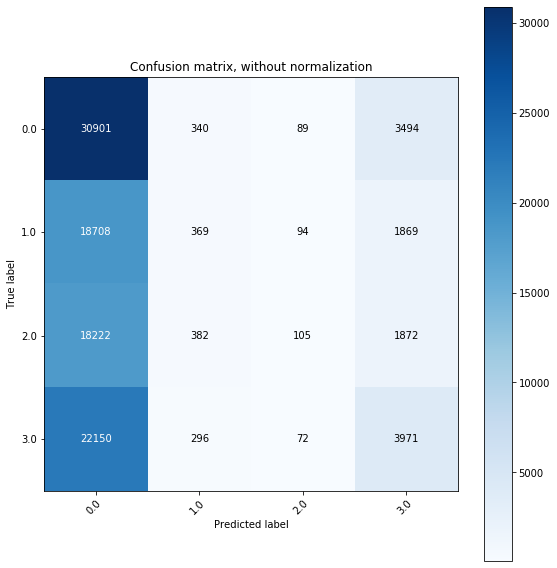

In [39]:
plot_confusion_matrix(val_y,
                      pred_class,
                      classes=np.unique(val_y),
                      title='Confusion matrix, without normalization')
plt.show()

In [40]:
len(pred_class)

102934

In [41]:
np.unique(pred_class,return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([89981,  1387,   360, 11206], dtype=int64))

In [42]:
np.unique(val_y,return_counts=True)

(array([0., 1., 2., 3.]), array([34824, 21040, 20581, 26489], dtype=int64))

### Repeat for 6-class

In [199]:
# have no sigmoid activation at the output layer & have the loss function expect logits

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]
model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(28, 28)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)
    keras.layers.Dense(6, input_shape=(FEATURES,), #activation='sigmoid',
                      kernel_regularizer=regularizers.l2(0.001))
])

model.summary()

# with final activation (Keras/TF tutorial advises against this practice, but they also use it later in the tutorial)
# model = keras.Sequential({
#   keras.layers.Dense(1, input_shape=(FEATURES,), activation='sigmoid')
# })

# #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', ])
# model.compile(
#               optimizer=keras.optimizers.Adam(), #lr=1e-3
#               loss=keras.losses.BinaryCrossentropy(from_logits=False),
#               metrics=METRICS)

# mostly used in TF tutorials is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_accuracy', 
                                                verbose=1,
                                                patience=100,
                                                mode='max',
                                                restore_best_weights=True)

def get_callbacks(run_id):
      return [
             tfdocs.modeling.EpochDots(),
             early_stopping,
             tf.keras.callbacks.TensorBoard(logdir), #/run_id),
      ]

baseline_history = model.fit(
                            train_ds, #train_features,
                            train_y, #train_labels,
                            batch_size=512, #BATCH_SIZE,
                            epochs=1000, #EPOCHS,
                            callbacks = get_callbacks('first'), #[early_stopping],
                            validation_data=(validate_ds, val_y),
                            verbose=1) #(val_features, val_labels))



Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 6)                 594       
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
785/805 [============================>.] - ETA: 0s - loss: 6.1693 - accuracy: 0.1932
Epoch: 0, accuracy:0.1940,  loss:6.0666,  val_accuracy:0.1846,  val_loss:1.8360,  
805/805 [==============================] - 2s 3ms/step - loss: 6.0666 - accuracy: 0.1940 - val_loss: 1.8360 - val_accuracy: 0.1846
Epoch 2/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7969 - accuracy: 0.2292 - val_loss: 1.7906 - val_accuracy: 0.2090
Epoch 3/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7709 - accuracy: 0.2333 - val_loss: 1.7910 - val_accuracy: 0.2122
Epoch 4/1000
805/805 [===========================

805/805 [==============================] - 2s 2ms/step - loss: 1.7643 - accuracy: 0.2366 - val_loss: 1.8007 - val_accuracy: 0.2143
Epoch 54/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7649 - accuracy: 0.2361 - val_loss: 1.7786 - val_accuracy: 0.2211
Epoch 55/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7642 - accuracy: 0.2370 - val_loss: 1.7884 - val_accuracy: 0.2243
Epoch 56/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7642 - accuracy: 0.2372 - val_loss: 1.7993 - val_accuracy: 0.2177
Epoch 57/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7659 - accuracy: 0.2370 - val_loss: 1.7926 - val_accuracy: 0.2166
Epoch 58/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7673 - accuracy: 0.2363 - val_loss: 1.7891 - val_accuracy: 0.2221
Epoch 59/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2370 - val_loss: 1.7818 - val_accuracy: 0.2221

805/805 [==============================] - 2s 2ms/step - loss: 1.7643 - accuracy: 0.2373 - val_loss: 1.7969 - val_accuracy: 0.2248
Epoch 165/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7647 - accuracy: 0.2366 - val_loss: 1.7989 - val_accuracy: 0.2195
Epoch 166/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7635 - accuracy: 0.2378 - val_loss: 1.7925 - val_accuracy: 0.2284
Epoch 167/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7617 - accuracy: 0.2366 - val_loss: 1.7836 - val_accuracy: 0.2130
Epoch 168/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7624 - accuracy: 0.2374 - val_loss: 1.7977 - val_accuracy: 0.2172
Epoch 169/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7620 - accuracy: 0.2377 - val_loss: 1.7790 - val_accuracy: 0.2190
Epoch 170/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7647 - accuracy: 0.2375 - val_loss: 1.7800 - val_accuracy: 

805/805 [==============================] - 2s 2ms/step - loss: 1.7633 - accuracy: 0.2362 - val_loss: 1.8066 - val_accuracy: 0.2203
Epoch 220/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7622 - accuracy: 0.2372 - val_loss: 1.7881 - val_accuracy: 0.2209
Epoch 221/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7620 - accuracy: 0.2370 - val_loss: 1.7891 - val_accuracy: 0.2190
Epoch 222/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2373 - val_loss: 1.7864 - val_accuracy: 0.2161
Epoch 223/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7621 - accuracy: 0.2364 - val_loss: 1.7864 - val_accuracy: 0.2123
Epoch 224/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7623 - accuracy: 0.2370 - val_loss: 1.7818 - val_accuracy: 0.2160
Epoch 225/1000
805/805 [==============================] - 2s 2ms/step - loss: 1.7637 - accuracy: 0.2362 - val_loss: 1.7886 - val_accuracy: 

In [227]:
print(max(baseline_history.history['val_accuracy']))
test_loss, test_acc = model.evaluate(validate_ds,  val_y, verbose=2)
test_acc

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(validate_ds)
predictions

binarized_pred_proba = np.zeros((predictions.shape[0], 2))
binarized_pred_proba[:,0] = predictions[:,0] + predictions[:,1] + predictions[:,2]
binarized_pred_proba[:,1] = predictions[:,3] + predictions[:,4] + predictions[:,5]
#binarized_pred_proba[:,2] = predictions[:,4] + predictions[:,5]
binarized_pred_proba

pred_class = np.argmax(predictions,axis=1)
pred_class

binarized_pred_class = pred_class.copy()
binarized_pred_class[binarized_pred_class==1] = 0
binarized_pred_class[binarized_pred_class==2] = 0
binarized_pred_class[binarized_pred_class==3] = 1
binarized_pred_class[binarized_pred_class==4] = 1
binarized_pred_class[binarized_pred_class==5] = 1
np.unique(binarized_pred_class)

binarized_y_class = val_y.copy()
binarized_y_class[binarized_y_class==1] = 0
binarized_y_class[binarized_y_class==2] = 0
binarized_y_class[binarized_y_class==3] = 1
binarized_y_class[binarized_y_class==4] = 1
binarized_y_class[binarized_y_class==5] = 1
np.unique(binarized_y_class)

# now calculate binarized accuracy and binarized AUC (from 4-class predictions)
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"Accuracy: {accuracy_score(binarized_y_class, binarized_pred_class)}")
print(f"AUC: {roc_auc_score(binarized_y_class, binarized_pred_proba[:,1])}")


0.23083724081516266
3217/3217 - 4s - loss: 1.7881 - accuracy: 0.2308
Accuracy: 0.5317970738531487
AUC: 0.5384814059317218


In [53]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    



In [230]:
cm = confusion_matrix(binarized_y_class, binarized_pred_class) #confusion_matrix(y_true, y_pred)
cm

array([[13657, 34099],
       [14095, 41083]], dtype=int64)

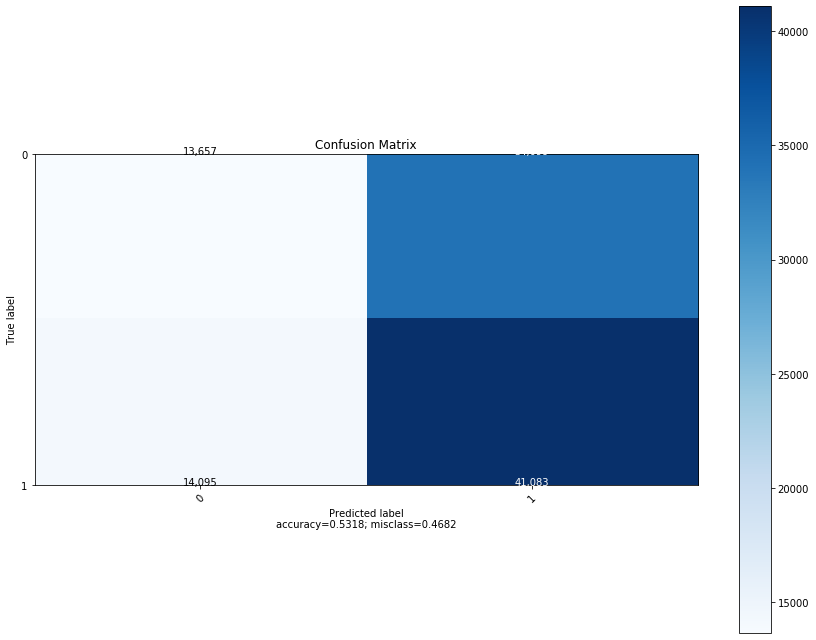

In [232]:
#cm = confusion_matrix(val_y, pred_class) #confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

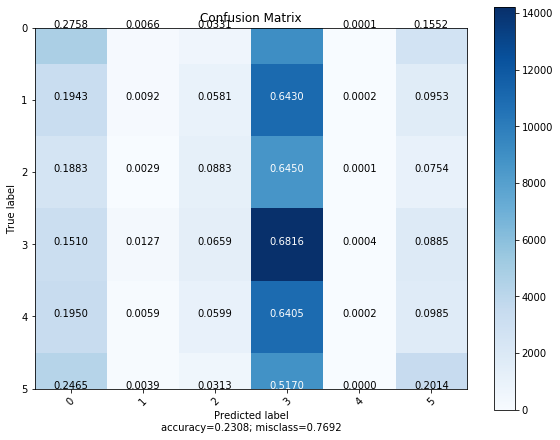

In [211]:
plot_confusion_matrix(cm           = cm,
                      normalize    = True,
                      target_names = ['0', '1', '2', '3', '4', '5'],
                      title        = "Confusion Matrix")

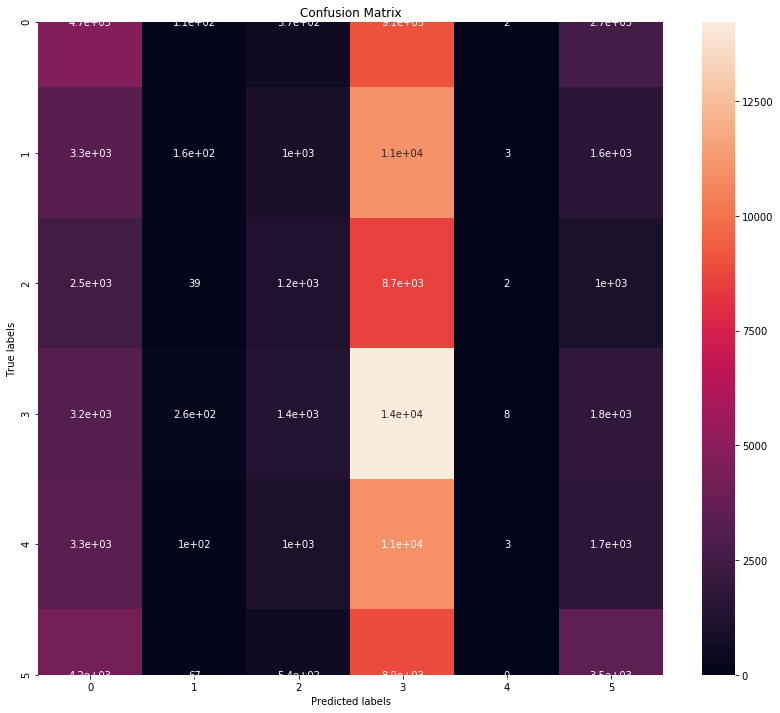

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt     

f, ax= plt.subplots(1,1,figsize=(14,12))
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

# Try the Keras tuner

In [40]:
#!pip install -q -U keras-tuner
#!python -m pip install keras-tuner
import kerastuner as kt
import IPython

In [47]:
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                     max_epochs = 50,
                     factor = 3)#,
                     #directory = 'my_dir_10082020',
                     #project_name = 'intro_to_kt_10082020') 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 50, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}.
""")    

INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal 
        L2 ratio is 0.0001 and the optimal learning rate for the optimizer
        is 0.001.



In [260]:
best_hps

In [48]:
tuner.results_summary(1)

In [269]:
tuner.results_summary(1)

TypeError: 'NoneType' object is not subscriptable

In [49]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(validate_ds, val_y)

3217/3217 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.3125 - auc: 0.63 - ETA: 4s - loss: 0.6958 - accuracy: 0.4905 - auc: 0.47 - ETA: 4s - loss: 0.6943 - accuracy: 0.4995 - auc: 0.50 - ETA: 4s - loss: 0.6936 - accuracy: 0.5077 - auc: 0.50 - ETA: 4s - loss: 0.6929 - accuracy: 0.5151 - auc: 0.51 - ETA: 4s - loss: 0.6924 - accuracy: 0.5183 - auc: 0.51 - ETA: 4s - loss: 0.6924 - accuracy: 0.5191 - auc: 0.51 - ETA: 4s - loss: 0.6927 - accuracy: 0.5184 - auc: 0.51 - ETA: 4s - loss: 0.6929 - accuracy: 0.5167 - auc: 0.51 - ETA: 4s - loss: 0.6933 - accuracy: 0.5144 - auc: 0.51 - ETA: 4s - loss: 0.6928 - accuracy: 0.5196 - auc: 0.51 - ETA: 4s - loss: 0.6918 - accuracy: 0.5246 - auc: 0.52 - ETA: 4s - loss: 0.6917 - accuracy: 0.5242 - auc: 0.51 - ETA: 4s - loss: 0.6909 - accuracy: 0.5277 - auc: 0.52 - ETA: 4s - loss: 0.6907 - accuracy: 0.5281 - auc: 0.53 - ETA: 4s - loss: 0.6904 - accuracy: 0.5297 - auc: 0.53 - ETA: 4s - loss: 0.6905 - accuracy: 0.5293 - auc: 0.53 - ETA

[0.6933012008666992, 0.5472633242607117, 0.5483337044715881]

In [ ]:
# original (weird labels, specific to each ticker)
# [0.6896852850914001, 0.5364311337471008, 0.543425977230072]

# fixed labels (label thresholds shared among all tickers)
# [0.6933012008666992, 0.5472633242607117, 0.5483337044715881]

In [267]:
tuner.results_summary()

In [264]:
tuner.get_best_models(num_models=1)

In [261]:
tuner.search_space_summary()

In [70]:
predictions = best_model.predict(validate_ds)
tmp = predictions - .5 #np.argmax(predictions, axis=1)
pred_class = tmp
pred_class[tmp < 0] = 0
pred_class[tmp >= 0] = 1 
pred_class

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [73]:
predictions - .5

array([[-0.44355834],
       [ 0.01069701],
       [ 0.02075905],
       ...,
       [-0.04266325],
       [-0.05875185],
       [-0.04162535]], dtype=float32)

In [60]:
np.unique(val_y)

array([0., 1.])

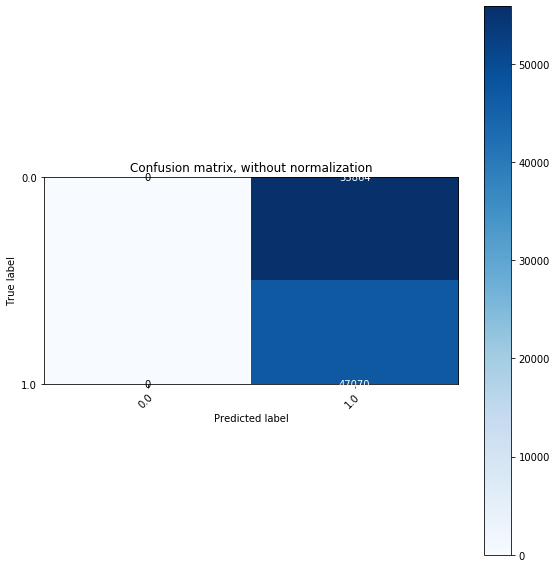

In [72]:
plot_confusion_matrix(val_y,
                      pred_class,
                      classes=np.unique(val_y),
                      title='Confusion matrix, without normalization')
plt.show()

### Try the other tuners

In [274]:
# using BayesianOptimization
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

#bayesian.BayesianOptimization
tuner = kt.BayesianOptimization(model_builder,
                                 objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                                 max_trials = 100,
                                 #factor = 3,
                                 directory = 'my_dir_2',
                                 project_name = 'intro_to_kt_2',
                                 seed=123) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = tuner.get_best_models(num_models=1)[0]
res = best_model.evaluate(validate_ds, val_y)

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}. Res is: {res}
""")    



Epoch 1/100
 3027/12867 [======>.......................] - ETA: 0s - loss: 22440.9473 - accuracy: 0.7188 - auc: 0.52 - ETA: 30s - loss: 7593.4287 - accuracy: 0.5506 - auc: 0.50 - ETA: 31s - loss: 4028.6638 - accuracy: 0.5053 - auc: 0.49 - ETA: 29s - loss: 2565.8328 - accuracy: 0.5067 - auc: 0.50 - ETA: 30s - loss: 1963.6013 - accuracy: 0.4938 - auc: 0.50 - ETA: 30s - loss: 1560.1361 - accuracy: 0.4918 - auc: 0.49 - ETA: 30s - loss: 1324.9932 - accuracy: 0.4950 - auc: 0.49 - ETA: 30s - loss: 1143.5842 - accuracy: 0.5047 - auc: 0.49 - ETA: 30s - loss: 999.8717 - accuracy: 0.5052 - auc: 0.4970 - ETA: 30s - loss: 874.3232 - accuracy: 0.5090 - auc: 0.497 - ETA: 29s - loss: 776.8043 - accuracy: 0.5118 - auc: 0.497 - ETA: 29s - loss: 707.7455 - accuracy: 0.5118 - auc: 0.499 - ETA: 30s - loss: 652.5098 - accuracy: 0.5132 - auc: 0.498 - ETA: 30s - loss: 603.0961 - accuracy: 0.5150 - auc: 0.499 - ETA: 30s - loss: 560.6464 - accuracy: 0.5150 - auc: 0.497 - ETA: 30s - loss: 525.4293 - accuracy: 0.

Epoch 2/100
 3226/12867 [======>.......................] - ETA: 0s - loss: 1.3232 - accuracy: 0.4688 - auc: 0.52 - ETA: 26s - loss: 0.9152 - accuracy: 0.5182 - auc: 0.457 - ETA: 27s - loss: 0.8930 - accuracy: 0.5027 - auc: 0.456 - ETA: 27s - loss: 0.9044 - accuracy: 0.5094 - auc: 0.466 - ETA: 27s - loss: 0.8964 - accuracy: 0.5138 - auc: 0.471 - ETA: 27s - loss: 0.8756 - accuracy: 0.5169 - auc: 0.484 - ETA: 26s - loss: 0.8788 - accuracy: 0.5125 - auc: 0.484 - ETA: 26s - loss: 0.8915 - accuracy: 0.5179 - auc: 0.490 - ETA: 26s - loss: 0.9343 - accuracy: 0.5161 - auc: 0.491 - ETA: 27s - loss: 0.9294 - accuracy: 0.5168 - auc: 0.492 - ETA: 26s - loss: 0.9256 - accuracy: 0.5170 - auc: 0.494 - ETA: 26s - loss: 0.9260 - accuracy: 0.5177 - auc: 0.497 - ETA: 26s - loss: 0.9264 - accuracy: 0.5200 - auc: 0.495 - ETA: 26s - loss: 0.9230 - accuracy: 0.5207 - auc: 0.497 - ETA: 26s - loss: 0.9176 - accuracy: 0.5220 - auc: 0.498 - ETA: 26s - loss: 0.9132 - accuracy: 0.5237 - auc: 0.500 - ETA: 26s - loss

 3182/12867 [======>.......................] - ETA: 0s - loss: 0.9048 - accuracy: 0.5000 - auc: 0.58 - ETA: 30s - loss: 0.8174 - accuracy: 0.5193 - auc: 0.543 - ETA: 29s - loss: 0.8396 - accuracy: 0.5284 - auc: 0.531 - ETA: 28s - loss: 0.8337 - accuracy: 0.5335 - auc: 0.526 - ETA: 28s - loss: 0.8551 - accuracy: 0.5363 - auc: 0.521 - ETA: 28s - loss: 0.8519 - accuracy: 0.5424 - auc: 0.519 - ETA: 28s - loss: 0.8460 - accuracy: 0.5380 - auc: 0.514 - ETA: 28s - loss: 0.8479 - accuracy: 0.5361 - auc: 0.504 - ETA: 27s - loss: 0.8647 - accuracy: 0.5318 - auc: 0.504 - ETA: 27s - loss: 0.8978 - accuracy: 0.5331 - auc: 0.505 - ETA: 27s - loss: 0.9024 - accuracy: 0.5317 - auc: 0.502 - ETA: 27s - loss: 0.9100 - accuracy: 0.5315 - auc: 0.502 - ETA: 27s - loss: 0.9078 - accuracy: 0.5298 - auc: 0.500 - ETA: 27s - loss: 0.9191 - accuracy: 0.5293 - auc: 0.503 - ETA: 27s - loss: 0.9383 - accuracy: 0.5304 - auc: 0.503 - ETA: 27s - loss: 0.9593 - accuracy: 0.5308 - auc: 0.503 - ETA: 27s - loss: 0.9614 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9341 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9347 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9346 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9348 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9348 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9347 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5307 - auc: 0.50 - ETA: 5s - loss: 0.9345 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5307 - auc: 0.50 - ETA: 4s - loss: 0.9341 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5307 - auc: 0.50 - E

 3615/12867 [=======>......................] - ETA: 0s - loss: 1.1031 - accuracy: 0.6250 - auc: 0.52 - ETA: 23s - loss: 0.8243 - accuracy: 0.5513 - auc: 0.549 - ETA: 24s - loss: 0.8320 - accuracy: 0.5451 - auc: 0.541 - ETA: 24s - loss: 0.9017 - accuracy: 0.5371 - auc: 0.523 - ETA: 24s - loss: 0.9085 - accuracy: 0.5333 - auc: 0.520 - ETA: 24s - loss: 0.8913 - accuracy: 0.5340 - auc: 0.519 - ETA: 23s - loss: 0.8752 - accuracy: 0.5378 - auc: 0.517 - ETA: 23s - loss: 0.8864 - accuracy: 0.5377 - auc: 0.518 - ETA: 24s - loss: 0.9043 - accuracy: 0.5405 - auc: 0.518 - ETA: 24s - loss: 0.9183 - accuracy: 0.5407 - auc: 0.517 - ETA: 24s - loss: 0.9059 - accuracy: 0.5401 - auc: 0.521 - ETA: 24s - loss: 0.9012 - accuracy: 0.5416 - auc: 0.520 - ETA: 25s - loss: 0.8976 - accuracy: 0.5421 - auc: 0.518 - ETA: 25s - loss: 0.8961 - accuracy: 0.5403 - auc: 0.517 - ETA: 25s - loss: 0.8957 - accuracy: 0.5422 - auc: 0.519 - ETA: 26s - loss: 0.8971 - accuracy: 0.5418 - auc: 0.517 - ETA: 26s - loss: 0.8936 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9341 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9337 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9346 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9356 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9354 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9348 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9345 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5310 - auc: 0.50 - E

 3377/12867 [======>.......................] - ETA: 0s - loss: 0.8925 - accuracy: 0.5000 - auc: 0.36 - ETA: 24s - loss: 1.1243 - accuracy: 0.5084 - auc: 0.495 - ETA: 25s - loss: 1.0820 - accuracy: 0.5206 - auc: 0.493 - ETA: 25s - loss: 1.0840 - accuracy: 0.5225 - auc: 0.500 - ETA: 26s - loss: 1.0260 - accuracy: 0.5226 - auc: 0.504 - ETA: 25s - loss: 1.0293 - accuracy: 0.5237 - auc: 0.504 - ETA: 25s - loss: 0.9902 - accuracy: 0.5300 - auc: 0.506 - ETA: 25s - loss: 0.9630 - accuracy: 0.5336 - auc: 0.507 - ETA: 25s - loss: 0.9496 - accuracy: 0.5369 - auc: 0.507 - ETA: 25s - loss: 0.9406 - accuracy: 0.5387 - auc: 0.507 - ETA: 25s - loss: 0.9326 - accuracy: 0.5396 - auc: 0.508 - ETA: 25s - loss: 0.9240 - accuracy: 0.5406 - auc: 0.510 - ETA: 25s - loss: 0.9157 - accuracy: 0.5398 - auc: 0.511 - ETA: 25s - loss: 0.9116 - accuracy: 0.5393 - auc: 0.510 - ETA: 25s - loss: 0.9242 - accuracy: 0.5392 - auc: 0.511 - ETA: 25s - loss: 0.9331 - accuracy: 0.5385 - auc: 0.512 - ETA: 25s - loss: 0.9546 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9338 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9346 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9341 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - E

 3398/12867 [======>.......................] - ETA: 0s - loss: 0.9340 - accuracy: 0.4062 - auc: 0.34 - ETA: 26s - loss: 0.8978 - accuracy: 0.5182 - auc: 0.481 - ETA: 27s - loss: 0.9331 - accuracy: 0.5149 - auc: 0.485 - ETA: 28s - loss: 0.9018 - accuracy: 0.5262 - auc: 0.502 - ETA: 28s - loss: 0.9044 - accuracy: 0.5302 - auc: 0.498 - ETA: 27s - loss: 0.9132 - accuracy: 0.5321 - auc: 0.504 - ETA: 27s - loss: 0.9386 - accuracy: 0.5283 - auc: 0.505 - ETA: 27s - loss: 0.9334 - accuracy: 0.5286 - auc: 0.506 - ETA: 26s - loss: 0.9426 - accuracy: 0.5271 - auc: 0.508 - ETA: 26s - loss: 0.9406 - accuracy: 0.5256 - auc: 0.507 - ETA: 26s - loss: 0.9363 - accuracy: 0.5264 - auc: 0.508 - ETA: 26s - loss: 0.9338 - accuracy: 0.5275 - auc: 0.506 - ETA: 26s - loss: 0.9330 - accuracy: 0.5302 - auc: 0.508 - ETA: 26s - loss: 0.9463 - accuracy: 0.5312 - auc: 0.511 - ETA: 26s - loss: 0.9476 - accuracy: 0.5299 - auc: 0.510 - ETA: 26s - loss: 0.9505 - accuracy: 0.5288 - auc: 0.510 - ETA: 26s - loss: 0.9453 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9362 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9360 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9359 - accuracy: 0.5302 - auc: 0.50 - ETA: 5s - loss: 0.9357 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9357 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9355 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9364 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9367 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9368 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9369 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9372 - accuracy: 0.5300 - auc: 0.50 - ETA: 4s - loss: 0.9369 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9366 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9363 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9361 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9359 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9360 - accuracy: 0.5302 - auc: 0.50 - E

 3375/12867 [======>.......................] - ETA: 0s - loss: 0.7741 - accuracy: 0.5938 - auc: 0.43 - ETA: 24s - loss: 1.0314 - accuracy: 0.5240 - auc: 0.486 - ETA: 24s - loss: 1.0243 - accuracy: 0.5276 - auc: 0.495 - ETA: 25s - loss: 1.0183 - accuracy: 0.5230 - auc: 0.488 - ETA: 25s - loss: 1.0343 - accuracy: 0.5254 - auc: 0.490 - ETA: 25s - loss: 1.0093 - accuracy: 0.5347 - auc: 0.501 - ETA: 25s - loss: 1.0023 - accuracy: 0.5358 - auc: 0.501 - ETA: 25s - loss: 0.9808 - accuracy: 0.5334 - auc: 0.502 - ETA: 25s - loss: 0.9795 - accuracy: 0.5316 - auc: 0.500 - ETA: 25s - loss: 0.9733 - accuracy: 0.5283 - auc: 0.502 - ETA: 25s - loss: 0.9570 - accuracy: 0.5304 - auc: 0.507 - ETA: 25s - loss: 0.9514 - accuracy: 0.5322 - auc: 0.506 - ETA: 25s - loss: 0.9716 - accuracy: 0.5306 - auc: 0.504 - ETA: 25s - loss: 0.9659 - accuracy: 0.5299 - auc: 0.505 - ETA: 25s - loss: 0.9593 - accuracy: 0.5306 - auc: 0.504 - ETA: 26s - loss: 0.9622 - accuracy: 0.5312 - auc: 0.503 - ETA: 26s - loss: 0.9627 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9333 - accuracy: 0.5315 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5315 - auc: 0.50 - ETA: 4s - loss: 0.9334 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9338 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9339 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9346 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9345 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9342 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9340 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9337 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9334 - accuracy: 0.5313 - auc: 0.50 - ETA: 4s - loss: 0.9333 - accuracy: 0.5314 - auc: 0.50 - ETA: 4s - loss: 0.9335 - accuracy: 0.5314 - auc: 0.50 - E

 3405/12867 [======>.......................] - ETA: 0s - loss: 0.8817 - accuracy: 0.5000 - auc: 0.40 - ETA: 29s - loss: 0.9482 - accuracy: 0.5597 - auc: 0.527 - ETA: 32s - loss: 0.9471 - accuracy: 0.5625 - auc: 0.521 - ETA: 32s - loss: 0.9123 - accuracy: 0.5553 - auc: 0.516 - ETA: 30s - loss: 0.9142 - accuracy: 0.5408 - auc: 0.507 - ETA: 29s - loss: 0.9071 - accuracy: 0.5420 - auc: 0.503 - ETA: 29s - loss: 0.9394 - accuracy: 0.5367 - auc: 0.498 - ETA: 29s - loss: 0.9262 - accuracy: 0.5333 - auc: 0.498 - ETA: 28s - loss: 0.9110 - accuracy: 0.5342 - auc: 0.499 - ETA: 28s - loss: 0.8966 - accuracy: 0.5362 - auc: 0.505 - ETA: 28s - loss: 0.8940 - accuracy: 0.5347 - auc: 0.504 - ETA: 28s - loss: 0.8889 - accuracy: 0.5357 - auc: 0.505 - ETA: 27s - loss: 0.8816 - accuracy: 0.5361 - auc: 0.506 - ETA: 27s - loss: 0.8834 - accuracy: 0.5329 - auc: 0.506 - ETA: 27s - loss: 0.8835 - accuracy: 0.5331 - auc: 0.504 - ETA: 27s - loss: 0.8907 - accuracy: 0.5336 - auc: 0.502 - ETA: 27s - loss: 0.8966 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9258 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9256 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9256 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9258 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9259 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9262 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9260 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9258 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9254 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9254 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9253 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9259 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9257 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9255 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9257 - accuracy: 0.5302 - auc: 0.50 - E

 3652/12867 [=======>......................] - ETA: 0s - loss: 1.0838 - accuracy: 0.3750 - auc: 0.36 - ETA: 23s - loss: 0.9566 - accuracy: 0.5536 - auc: 0.500 - ETA: 23s - loss: 0.9544 - accuracy: 0.5437 - auc: 0.507 - ETA: 24s - loss: 0.9387 - accuracy: 0.5411 - auc: 0.506 - ETA: 24s - loss: 0.9503 - accuracy: 0.5410 - auc: 0.511 - ETA: 25s - loss: 0.9387 - accuracy: 0.5396 - auc: 0.509 - ETA: 25s - loss: 0.9350 - accuracy: 0.5368 - auc: 0.501 - ETA: 24s - loss: 0.9368 - accuracy: 0.5398 - auc: 0.504 - ETA: 24s - loss: 0.9289 - accuracy: 0.5399 - auc: 0.502 - ETA: 24s - loss: 0.9172 - accuracy: 0.5406 - auc: 0.500 - ETA: 24s - loss: 0.9100 - accuracy: 0.5417 - auc: 0.503 - ETA: 24s - loss: 0.9038 - accuracy: 0.5378 - auc: 0.500 - ETA: 24s - loss: 0.8991 - accuracy: 0.5371 - auc: 0.499 - ETA: 24s - loss: 0.8995 - accuracy: 0.5363 - auc: 0.500 - ETA: 24s - loss: 0.9042 - accuracy: 0.5330 - auc: 0.500 - ETA: 24s - loss: 0.9032 - accuracy: 0.5323 - auc: 0.501 - ETA: 24s - loss: 0.9185 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9334 - accuracy: 0.5310 - auc: 0.50 - ETA: 3s - loss: 0.9332 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9335 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9333 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5309 - auc: 0.50 - ETA: 3s - loss: 0.9328 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9325 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9325 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9328 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9333 - accuracy: 0.5309 - auc: 0.50 - ETA: 2s - loss: 0.9335 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9337 - accuracy: 0.5307 - auc: 0.50 - ETA: 2s - loss: 0.9338 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9337 - accuracy: 0.5308 - auc: 0.50 - ETA: 2s - loss: 0.9334 - accuracy: 0.5308 - auc: 0.50 - E

 3664/12867 [=======>......................] - ETA: 0s - loss: 1.0262 - accuracy: 0.5312 - auc: 0.49 - ETA: 23s - loss: 1.0124 - accuracy: 0.5391 - auc: 0.523 - ETA: 23s - loss: 1.0621 - accuracy: 0.5352 - auc: 0.514 - ETA: 23s - loss: 1.0451 - accuracy: 0.5332 - auc: 0.521 - ETA: 24s - loss: 1.0110 - accuracy: 0.5354 - auc: 0.515 - ETA: 24s - loss: 0.9820 - accuracy: 0.5371 - auc: 0.512 - ETA: 23s - loss: 0.9671 - accuracy: 0.5363 - auc: 0.506 - ETA: 24s - loss: 0.9596 - accuracy: 0.5338 - auc: 0.503 - ETA: 24s - loss: 0.9500 - accuracy: 0.5348 - auc: 0.507 - ETA: 24s - loss: 0.9419 - accuracy: 0.5360 - auc: 0.509 - ETA: 24s - loss: 0.9336 - accuracy: 0.5361 - auc: 0.507 - ETA: 24s - loss: 0.9334 - accuracy: 0.5358 - auc: 0.507 - ETA: 24s - loss: 0.9336 - accuracy: 0.5327 - auc: 0.505 - ETA: 24s - loss: 0.9350 - accuracy: 0.5333 - auc: 0.503 - ETA: 24s - loss: 0.9249 - accuracy: 0.5349 - auc: 0.502 - ETA: 24s - loss: 0.9216 - accuracy: 0.5353 - auc: 0.503 - ETA: 24s - loss: 0.9307 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9337 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5310 - auc: 0.50 - ETA: 3s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9338 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9335 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9333 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9330 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9332 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9336 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9342 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 2s - loss: 0.9344 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9345 - accuracy: 0.5311 - auc: 0.50 - ETA: 2s - loss: 0.9347 - accuracy: 0.5312 - auc: 0.50 - ETA: 2s - loss: 0.9348 - accuracy: 0.5311 - auc: 0.50 - E

 3572/12867 [=======>......................] - ETA: 0s - loss: 0.7588 - accuracy: 0.6250 - auc: 0.60 - ETA: 25s - loss: 0.8666 - accuracy: 0.5421 - auc: 0.512 - ETA: 24s - loss: 0.8995 - accuracy: 0.5442 - auc: 0.507 - ETA: 24s - loss: 0.8886 - accuracy: 0.5430 - auc: 0.507 - ETA: 24s - loss: 0.8746 - accuracy: 0.5415 - auc: 0.500 - ETA: 24s - loss: 0.9715 - accuracy: 0.5406 - auc: 0.504 - ETA: 24s - loss: 1.0019 - accuracy: 0.5402 - auc: 0.501 - ETA: 24s - loss: 1.0369 - accuracy: 0.5381 - auc: 0.501 - ETA: 23s - loss: 1.0343 - accuracy: 0.5365 - auc: 0.502 - ETA: 24s - loss: 1.0377 - accuracy: 0.5299 - auc: 0.497 - ETA: 24s - loss: 1.0334 - accuracy: 0.5290 - auc: 0.497 - ETA: 23s - loss: 1.0160 - accuracy: 0.5286 - auc: 0.494 - ETA: 24s - loss: 1.0016 - accuracy: 0.5275 - auc: 0.496 - ETA: 23s - loss: 0.9893 - accuracy: 0.5268 - auc: 0.496 - ETA: 23s - loss: 0.9809 - accuracy: 0.5250 - auc: 0.496 - ETA: 23s - loss: 0.9739 - accuracy: 0.5249 - auc: 0.498 - ETA: 23s - loss: 0.9781 - a

12867/12867 [==============================] - ETA: 4s - loss: 0.9397 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 4s - loss: 0.9398 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9394 - accuracy: 0.5299 - auc: 0.50 - ETA: 4s - loss: 0.9391 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9392 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9396 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9393 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9391 - accuracy: 0.5300 - auc: 0.50 - E

 3380/12867 [======>.......................] - ETA: 0s - loss: 0.8311 - accuracy: 0.6250 - auc: 0.65 - ETA: 25s - loss: 0.9010 - accuracy: 0.5433 - auc: 0.508 - ETA: 25s - loss: 0.9293 - accuracy: 0.5331 - auc: 0.508 - ETA: 26s - loss: 0.9304 - accuracy: 0.5368 - auc: 0.505 - ETA: 26s - loss: 0.9282 - accuracy: 0.5341 - auc: 0.498 - ETA: 26s - loss: 0.9302 - accuracy: 0.5356 - auc: 0.503 - ETA: 26s - loss: 0.9395 - accuracy: 0.5371 - auc: 0.505 - ETA: 26s - loss: 0.9443 - accuracy: 0.5357 - auc: 0.505 - ETA: 26s - loss: 0.9383 - accuracy: 0.5350 - auc: 0.506 - ETA: 26s - loss: 0.9210 - accuracy: 0.5389 - auc: 0.507 - ETA: 26s - loss: 0.9233 - accuracy: 0.5401 - auc: 0.507 - ETA: 26s - loss: 0.9214 - accuracy: 0.5382 - auc: 0.506 - ETA: 26s - loss: 0.9208 - accuracy: 0.5358 - auc: 0.505 - ETA: 26s - loss: 0.9273 - accuracy: 0.5315 - auc: 0.504 - ETA: 26s - loss: 0.9307 - accuracy: 0.5313 - auc: 0.504 - ETA: 26s - loss: 0.9281 - accuracy: 0.5298 - auc: 0.505 - ETA: 26s - loss: 0.9190 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9378 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9375 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9374 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9390 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9396 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9398 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9396 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9393 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9391 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9389 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9396 - accuracy: 0.5312 - auc: 0.50 - ETA: 4s - loss: 0.9398 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9397 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9395 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9392 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9393 - accuracy: 0.5310 - auc: 0.50 - E

 3376/12867 [======>.......................] - ETA: 0s - loss: 0.8863 - accuracy: 0.3125 - auc: 0.76 - ETA: 24s - loss: 0.9825 - accuracy: 0.5252 - auc: 0.506 - ETA: 25s - loss: 0.9464 - accuracy: 0.5276 - auc: 0.491 - ETA: 25s - loss: 0.9801 - accuracy: 0.5215 - auc: 0.487 - ETA: 25s - loss: 0.9803 - accuracy: 0.5233 - auc: 0.487 - ETA: 25s - loss: 0.9692 - accuracy: 0.5255 - auc: 0.487 - ETA: 25s - loss: 0.9469 - accuracy: 0.5260 - auc: 0.488 - ETA: 25s - loss: 0.9346 - accuracy: 0.5257 - auc: 0.492 - ETA: 25s - loss: 0.9343 - accuracy: 0.5222 - auc: 0.493 - ETA: 25s - loss: 0.9245 - accuracy: 0.5262 - auc: 0.496 - ETA: 25s - loss: 0.9113 - accuracy: 0.5297 - auc: 0.500 - ETA: 25s - loss: 0.9098 - accuracy: 0.5281 - auc: 0.499 - ETA: 25s - loss: 0.9199 - accuracy: 0.5291 - auc: 0.503 - ETA: 25s - loss: 0.9142 - accuracy: 0.5274 - auc: 0.503 - ETA: 25s - loss: 0.9134 - accuracy: 0.5281 - auc: 0.503 - ETA: 25s - loss: 0.9219 - accuracy: 0.5267 - auc: 0.501 - ETA: 25s - loss: 0.9186 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5321 - auc: 0.50 - ETA: 5s - loss: 0.9333 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5320 - auc: 0.50 - ETA: 5s - loss: 0.9332 - accuracy: 0.5319 - auc: 0.50 - ETA: 5s - loss: 0.9329 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9327 - accuracy: 0.5321 - auc: 0.50 - ETA: 4s - loss: 0.9331 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9330 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9326 - accuracy: 0.5321 - auc: 0.50 - ETA: 4s - loss: 0.9325 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9324 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9324 - accuracy: 0.5320 - auc: 0.50 - ETA: 4s - loss: 0.9323 - accuracy: 0.5320 - auc: 0.50 - E

 3401/12867 [======>.......................] - ETA: 0s - loss: 0.9414 - accuracy: 0.5625 - auc: 0.55 - ETA: 24s - loss: 1.0425 - accuracy: 0.5036 - auc: 0.505 - ETA: 25s - loss: 1.0623 - accuracy: 0.5061 - auc: 0.489 - ETA: 25s - loss: 0.9993 - accuracy: 0.5201 - auc: 0.490 - ETA: 25s - loss: 0.9842 - accuracy: 0.5209 - auc: 0.493 - ETA: 26s - loss: 0.9923 - accuracy: 0.5212 - auc: 0.489 - ETA: 25s - loss: 0.9591 - accuracy: 0.5252 - auc: 0.488 - ETA: 25s - loss: 0.9478 - accuracy: 0.5224 - auc: 0.483 - ETA: 25s - loss: 0.9411 - accuracy: 0.5194 - auc: 0.484 - ETA: 25s - loss: 0.9340 - accuracy: 0.5162 - auc: 0.483 - ETA: 26s - loss: 0.9480 - accuracy: 0.5185 - auc: 0.485 - ETA: 26s - loss: 0.9512 - accuracy: 0.5182 - auc: 0.486 - ETA: 26s - loss: 0.9407 - accuracy: 0.5180 - auc: 0.486 - ETA: 26s - loss: 0.9346 - accuracy: 0.5188 - auc: 0.486 - ETA: 25s - loss: 0.9328 - accuracy: 0.5205 - auc: 0.487 - ETA: 25s - loss: 0.9278 - accuracy: 0.5198 - auc: 0.484 - ETA: 25s - loss: 0.9454 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9313 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9312 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9316 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9319 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9317 - accuracy: 0.5295 - auc: 0.50 - ETA: 5s - loss: 0.9315 - accuracy: 0.5294 - auc: 0.50 - ETA: 5s - loss: 0.9312 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9310 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5294 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5293 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5292 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5293 - auc: 0.50 - E

 3534/12867 [=======>......................] - ETA: 0s - loss: 0.7858 - accuracy: 0.5000 - auc: 0.46 - ETA: 28s - loss: 0.8094 - accuracy: 0.5136 - auc: 0.511 - ETA: 28s - loss: 0.8769 - accuracy: 0.5292 - auc: 0.507 - ETA: 27s - loss: 0.8741 - accuracy: 0.5295 - auc: 0.504 - ETA: 27s - loss: 0.8910 - accuracy: 0.5234 - auc: 0.498 - ETA: 26s - loss: 0.8982 - accuracy: 0.5243 - auc: 0.497 - ETA: 26s - loss: 0.9209 - accuracy: 0.5251 - auc: 0.501 - ETA: 26s - loss: 0.9120 - accuracy: 0.5253 - auc: 0.499 - ETA: 26s - loss: 0.9038 - accuracy: 0.5271 - auc: 0.499 - ETA: 26s - loss: 0.8912 - accuracy: 0.5300 - auc: 0.500 - ETA: 25s - loss: 0.9021 - accuracy: 0.5294 - auc: 0.499 - ETA: 25s - loss: 0.9141 - accuracy: 0.5260 - auc: 0.499 - ETA: 25s - loss: 0.9130 - accuracy: 0.5266 - auc: 0.501 - ETA: 25s - loss: 0.9096 - accuracy: 0.5247 - auc: 0.500 - ETA: 25s - loss: 0.9059 - accuracy: 0.5261 - auc: 0.501 - ETA: 25s - loss: 0.9026 - accuracy: 0.5258 - auc: 0.501 - ETA: 25s - loss: 0.8956 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9423 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9421 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9419 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9418 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9416 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9413 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9410 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9411 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9419 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9418 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5302 - auc: 0.50 - ETA: 4s - loss: 0.9422 - accuracy: 0.5301 - auc: 0.50 - ETA: 4s - loss: 0.9421 - accuracy: 0.5301 - auc: 0.50 - E

 3276/12867 [======>.......................] - ETA: 0s - loss: 0.9059 - accuracy: 0.5625 - auc: 0.45 - ETA: 23s - loss: 0.8686 - accuracy: 0.5174 - auc: 0.486 - ETA: 24s - loss: 0.8877 - accuracy: 0.5212 - auc: 0.504 - ETA: 26s - loss: 0.8784 - accuracy: 0.5232 - auc: 0.509 - ETA: 26s - loss: 0.8920 - accuracy: 0.5185 - auc: 0.507 - ETA: 26s - loss: 0.9563 - accuracy: 0.5112 - auc: 0.497 - ETA: 26s - loss: 0.9494 - accuracy: 0.5127 - auc: 0.495 - ETA: 26s - loss: 0.9379 - accuracy: 0.5130 - auc: 0.497 - ETA: 25s - loss: 0.9224 - accuracy: 0.5152 - auc: 0.495 - ETA: 25s - loss: 0.9339 - accuracy: 0.5177 - auc: 0.494 - ETA: 25s - loss: 0.9296 - accuracy: 0.5171 - auc: 0.494 - ETA: 25s - loss: 0.9378 - accuracy: 0.5190 - auc: 0.497 - ETA: 25s - loss: 0.9376 - accuracy: 0.5192 - auc: 0.497 - ETA: 25s - loss: 0.9385 - accuracy: 0.5169 - auc: 0.496 - ETA: 25s - loss: 0.9324 - accuracy: 0.5195 - auc: 0.497 - ETA: 25s - loss: 0.9335 - accuracy: 0.5207 - auc: 0.499 - ETA: 25s - loss: 0.9335 - a

12867/12867 [==============================] - ETA: 6s - loss: 0.9344 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9343 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9340 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9339 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9338 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9336 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9334 - accuracy: 0.5312 - auc: 0.50 - ETA: 5s - loss: 0.9335 - accuracy: 0.5313 - auc: 0.50 - ETA: 5s - loss: 0.9337 - accuracy: 0.5312 - auc: 0.50 - E

 3612/12867 [=======>......................] - ETA: 0s - loss: 0.8618 - accuracy: 0.5625 - auc: 0.48 - ETA: 23s - loss: 0.9011 - accuracy: 0.5424 - auc: 0.497 - ETA: 24s - loss: 0.9211 - accuracy: 0.5306 - auc: 0.491 - ETA: 24s - loss: 0.9974 - accuracy: 0.5288 - auc: 0.506 - ETA: 24s - loss: 0.9989 - accuracy: 0.5235 - auc: 0.498 - ETA: 24s - loss: 0.9995 - accuracy: 0.5222 - auc: 0.499 - ETA: 24s - loss: 0.9802 - accuracy: 0.5243 - auc: 0.498 - ETA: 24s - loss: 0.9710 - accuracy: 0.5229 - auc: 0.495 - ETA: 24s - loss: 0.9573 - accuracy: 0.5259 - auc: 0.500 - ETA: 24s - loss: 0.9440 - accuracy: 0.5295 - auc: 0.501 - ETA: 24s - loss: 0.9357 - accuracy: 0.5293 - auc: 0.499 - ETA: 24s - loss: 0.9475 - accuracy: 0.5302 - auc: 0.500 - ETA: 24s - loss: 0.9465 - accuracy: 0.5312 - auc: 0.502 - ETA: 24s - loss: 0.9401 - accuracy: 0.5318 - auc: 0.503 - ETA: 24s - loss: 0.9446 - accuracy: 0.5330 - auc: 0.505 - ETA: 24s - loss: 0.9380 - accuracy: 0.5340 - auc: 0.506 - ETA: 24s - loss: 0.9335 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9360 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9359 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9357 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9354 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9355 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9355 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9353 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9353 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9350 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9352 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9351 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9348 - accuracy: 0.5298 - auc: 0.50 - E

 3539/12867 [=======>......................] - ETA: 0s - loss: 0.8155 - accuracy: 0.4688 - auc: 0.53 - ETA: 23s - loss: 0.8275 - accuracy: 0.5127 - auc: 0.471 - ETA: 23s - loss: 0.9280 - accuracy: 0.5145 - auc: 0.478 - ETA: 24s - loss: 0.9471 - accuracy: 0.5145 - auc: 0.477 - ETA: 24s - loss: 0.9667 - accuracy: 0.5239 - auc: 0.486 - ETA: 24s - loss: 0.9571 - accuracy: 0.5231 - auc: 0.488 - ETA: 24s - loss: 0.9620 - accuracy: 0.5246 - auc: 0.490 - ETA: 25s - loss: 0.9481 - accuracy: 0.5238 - auc: 0.493 - ETA: 25s - loss: 0.9509 - accuracy: 0.5232 - auc: 0.494 - ETA: 26s - loss: 0.9461 - accuracy: 0.5242 - auc: 0.496 - ETA: 25s - loss: 0.9376 - accuracy: 0.5249 - auc: 0.494 - ETA: 25s - loss: 0.9593 - accuracy: 0.5258 - auc: 0.496 - ETA: 25s - loss: 0.9759 - accuracy: 0.5241 - auc: 0.496 - ETA: 25s - loss: 0.9739 - accuracy: 0.5238 - auc: 0.495 - ETA: 25s - loss: 0.9662 - accuracy: 0.5274 - auc: 0.498 - ETA: 25s - loss: 0.9558 - accuracy: 0.5262 - auc: 0.496 - ETA: 25s - loss: 0.9491 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9312 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9309 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9308 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 2s - loss: 0.9309 - accuracy: 0.5305 - auc: 0.50 - ETA: 2s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3514/12867 [=======>......................] - ETA: 0s - loss: 0.8503 - accuracy: 0.4688 - auc: 0.52 - ETA: 23s - loss: 0.8271 - accuracy: 0.5201 - auc: 0.496 - ETA: 23s - loss: 0.9094 - accuracy: 0.5244 - auc: 0.491 - ETA: 23s - loss: 0.9183 - accuracy: 0.5255 - auc: 0.502 - ETA: 25s - loss: 0.9107 - accuracy: 0.5273 - auc: 0.510 - ETA: 26s - loss: 0.8922 - accuracy: 0.5318 - auc: 0.516 - ETA: 25s - loss: 0.9006 - accuracy: 0.5312 - auc: 0.512 - ETA: 26s - loss: 0.8895 - accuracy: 0.5356 - auc: 0.512 - ETA: 26s - loss: 0.8889 - accuracy: 0.5365 - auc: 0.511 - ETA: 25s - loss: 0.8867 - accuracy: 0.5406 - auc: 0.511 - ETA: 25s - loss: 0.8871 - accuracy: 0.5398 - auc: 0.509 - ETA: 25s - loss: 0.8938 - accuracy: 0.5377 - auc: 0.509 - ETA: 25s - loss: 0.9114 - accuracy: 0.5371 - auc: 0.509 - ETA: 25s - loss: 0.9229 - accuracy: 0.5374 - auc: 0.507 - ETA: 25s - loss: 0.9183 - accuracy: 0.5374 - auc: 0.506 - ETA: 25s - loss: 0.9216 - accuracy: 0.5347 - auc: 0.503 - ETA: 25s - loss: 0.9163 - a

12867/12867 [==============================] - ETA: 4s - loss: 0.9338 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9336 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9335 - accuracy: 0.5306 - auc: 0.50 - ETA: 4s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9326 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9329 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9333 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9336 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9334 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9332 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9330 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9327 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9326 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9325 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9323 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9321 - accuracy: 0.5306 - auc: 0.50 - E

 3333/12867 [======>.......................] - ETA: 0s - loss: 1.1817 - accuracy: 0.4375 - auc: 0.41 - ETA: 25s - loss: 1.0278 - accuracy: 0.5412 - auc: 0.534 - ETA: 26s - loss: 1.0219 - accuracy: 0.5293 - auc: 0.516 - ETA: 26s - loss: 0.9685 - accuracy: 0.5458 - auc: 0.534 - ETA: 26s - loss: 0.9325 - accuracy: 0.5454 - auc: 0.533 - ETA: 26s - loss: 0.9079 - accuracy: 0.5455 - auc: 0.529 - ETA: 27s - loss: 0.9027 - accuracy: 0.5428 - auc: 0.521 - ETA: 26s - loss: 0.9237 - accuracy: 0.5444 - auc: 0.521 - ETA: 26s - loss: 0.9312 - accuracy: 0.5415 - auc: 0.517 - ETA: 26s - loss: 0.9285 - accuracy: 0.5360 - auc: 0.514 - ETA: 26s - loss: 0.9146 - accuracy: 0.5395 - auc: 0.516 - ETA: 26s - loss: 0.9118 - accuracy: 0.5364 - auc: 0.514 - ETA: 26s - loss: 0.9172 - accuracy: 0.5320 - auc: 0.509 - ETA: 26s - loss: 0.9157 - accuracy: 0.5326 - auc: 0.509 - ETA: 26s - loss: 0.9167 - accuracy: 0.5326 - auc: 0.510 - ETA: 26s - loss: 0.9190 - accuracy: 0.5340 - auc: 0.510 - ETA: 26s - loss: 0.9165 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9384 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9383 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9380 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9378 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9375 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9373 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9370 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9369 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9368 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9367 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9366 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9365 - accuracy: 0.5305 - auc: 0.50 - E

 3331/12867 [======>.......................] - ETA: 0s - loss: 0.7847 - accuracy: 0.6250 - auc: 0.48 - ETA: 25s - loss: 0.8661 - accuracy: 0.5288 - auc: 0.508 - ETA: 25s - loss: 0.8707 - accuracy: 0.5343 - auc: 0.508 - ETA: 26s - loss: 0.9307 - accuracy: 0.5359 - auc: 0.489 - ETA: 26s - loss: 0.9214 - accuracy: 0.5267 - auc: 0.491 - ETA: 26s - loss: 0.8976 - accuracy: 0.5349 - auc: 0.495 - ETA: 26s - loss: 0.8936 - accuracy: 0.5358 - auc: 0.499 - ETA: 27s - loss: 0.8974 - accuracy: 0.5414 - auc: 0.503 - ETA: 27s - loss: 0.8941 - accuracy: 0.5420 - auc: 0.506 - ETA: 27s - loss: 0.9087 - accuracy: 0.5383 - auc: 0.503 - ETA: 27s - loss: 0.9354 - accuracy: 0.5379 - auc: 0.503 - ETA: 26s - loss: 0.9312 - accuracy: 0.5360 - auc: 0.500 - ETA: 27s - loss: 0.9342 - accuracy: 0.5368 - auc: 0.500 - ETA: 27s - loss: 0.9325 - accuracy: 0.5369 - auc: 0.500 - ETA: 26s - loss: 0.9301 - accuracy: 0.5374 - auc: 0.502 - ETA: 26s - loss: 0.9252 - accuracy: 0.5354 - auc: 0.501 - ETA: 26s - loss: 0.9335 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9352 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9351 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9355 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9361 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9363 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9364 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9362 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9360 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9358 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9355 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9354 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9362 - accuracy: 0.5305 - auc: 0.50 - E

 3354/12867 [======>.......................] - ETA: 0s - loss: 1.0410 - accuracy: 0.4688 - auc: 0.46 - ETA: 26s - loss: 0.8207 - accuracy: 0.5263 - auc: 0.490 - ETA: 27s - loss: 0.9405 - accuracy: 0.5246 - auc: 0.515 - ETA: 28s - loss: 0.9592 - accuracy: 0.5267 - auc: 0.508 - ETA: 27s - loss: 0.9907 - accuracy: 0.5319 - auc: 0.512 - ETA: 26s - loss: 0.9827 - accuracy: 0.5341 - auc: 0.513 - ETA: 26s - loss: 0.9783 - accuracy: 0.5356 - auc: 0.515 - ETA: 26s - loss: 0.9702 - accuracy: 0.5352 - auc: 0.514 - ETA: 26s - loss: 0.9549 - accuracy: 0.5360 - auc: 0.514 - ETA: 26s - loss: 0.9667 - accuracy: 0.5356 - auc: 0.512 - ETA: 26s - loss: 0.9814 - accuracy: 0.5323 - auc: 0.504 - ETA: 26s - loss: 0.9812 - accuracy: 0.5297 - auc: 0.504 - ETA: 26s - loss: 0.9883 - accuracy: 0.5297 - auc: 0.507 - ETA: 26s - loss: 0.9939 - accuracy: 0.5309 - auc: 0.509 - ETA: 26s - loss: 0.9837 - accuracy: 0.5312 - auc: 0.510 - ETA: 26s - loss: 0.9802 - accuracy: 0.5298 - auc: 0.510 - ETA: 26s - loss: 0.9786 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9394 - accuracy: 0.5296 - auc: 0.50 - ETA: 5s - loss: 0.9393 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9391 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9389 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9392 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9388 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9386 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9385 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9384 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9382 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5298 - auc: 0.50 - ETA: 5s - loss: 0.9381 - accuracy: 0.5297 - auc: 0.50 - ETA: 5s - loss: 0.9379 - accuracy: 0.5298 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5297 - auc: 0.50 - ETA: 4s - loss: 0.9376 - accuracy: 0.5297 - auc: 0.50 - E

 3565/12867 [=======>......................] - ETA: 0s - loss: 1.0494 - accuracy: 0.5312 - auc: 0.34 - ETA: 22s - loss: 1.0065 - accuracy: 0.5301 - auc: 0.511 - ETA: 23s - loss: 0.9668 - accuracy: 0.5193 - auc: 0.515 - ETA: 23s - loss: 0.9858 - accuracy: 0.5286 - auc: 0.516 - ETA: 23s - loss: 0.9761 - accuracy: 0.5267 - auc: 0.513 - ETA: 23s - loss: 0.9870 - accuracy: 0.5271 - auc: 0.513 - ETA: 23s - loss: 0.9586 - accuracy: 0.5307 - auc: 0.512 - ETA: 24s - loss: 0.9540 - accuracy: 0.5331 - auc: 0.509 - ETA: 25s - loss: 0.9409 - accuracy: 0.5337 - auc: 0.506 - ETA: 25s - loss: 0.9335 - accuracy: 0.5324 - auc: 0.502 - ETA: 26s - loss: 0.9236 - accuracy: 0.5321 - auc: 0.502 - ETA: 26s - loss: 0.9190 - accuracy: 0.5294 - auc: 0.499 - ETA: 26s - loss: 0.9505 - accuracy: 0.5275 - auc: 0.495 - ETA: 25s - loss: 0.9631 - accuracy: 0.5267 - auc: 0.497 - ETA: 25s - loss: 0.9549 - accuracy: 0.5291 - auc: 0.495 - ETA: 25s - loss: 0.9569 - accuracy: 0.5277 - auc: 0.493 - ETA: 25s - loss: 0.9514 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9305 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5311 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9306 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5312 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5313 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9298 - accuracy: 0.5314 - auc: 0.50 - ETA: 3s - loss: 0.9300 - accuracy: 0.5315 - auc: 0.50 - E

 3632/12867 [=======>......................] - ETA: 0s - loss: 0.9734 - accuracy: 0.4375 - auc: 0.29 - ETA: 23s - loss: 0.8382 - accuracy: 0.5603 - auc: 0.554 - ETA: 24s - loss: 0.8417 - accuracy: 0.5472 - auc: 0.533 - ETA: 24s - loss: 0.9174 - accuracy: 0.5401 - auc: 0.522 - ETA: 24s - loss: 0.9099 - accuracy: 0.5421 - auc: 0.528 - ETA: 24s - loss: 0.8965 - accuracy: 0.5434 - auc: 0.526 - ETA: 24s - loss: 0.8879 - accuracy: 0.5402 - auc: 0.519 - ETA: 24s - loss: 0.8877 - accuracy: 0.5342 - auc: 0.510 - ETA: 24s - loss: 0.8805 - accuracy: 0.5366 - auc: 0.510 - ETA: 24s - loss: 0.8816 - accuracy: 0.5342 - auc: 0.509 - ETA: 24s - loss: 0.8940 - accuracy: 0.5320 - auc: 0.505 - ETA: 24s - loss: 0.8990 - accuracy: 0.5333 - auc: 0.508 - ETA: 24s - loss: 0.8919 - accuracy: 0.5326 - auc: 0.508 - ETA: 23s - loss: 0.9173 - accuracy: 0.5320 - auc: 0.507 - ETA: 23s - loss: 0.9467 - accuracy: 0.5318 - auc: 0.506 - ETA: 23s - loss: 0.9671 - accuracy: 0.5301 - auc: 0.506 - ETA: 23s - loss: 0.9659 - a

12867/12867 [==============================] - ETA: 4s - loss: 0.9313 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9311 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9310 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5304 - auc: 0.50 - ETA: 4s - loss: 0.9304 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9302 - accuracy: 0.5303 - auc: 0.50 - ETA: 4s - loss: 0.9300 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9302 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9303 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5303 - auc: 0.50 - ETA: 3s - loss: 0.9301 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5304 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9299 - accuracy: 0.5306 - auc: 0.50 - E

 3629/12867 [=======>......................] - ETA: 0s - loss: 0.7956 - accuracy: 0.5625 - auc: 0.50 - ETA: 22s - loss: 0.9220 - accuracy: 0.5246 - auc: 0.474 - ETA: 23s - loss: 0.9300 - accuracy: 0.5330 - auc: 0.512 - ETA: 23s - loss: 0.9411 - accuracy: 0.5386 - auc: 0.511 - ETA: 23s - loss: 0.9141 - accuracy: 0.5428 - auc: 0.510 - ETA: 24s - loss: 0.9266 - accuracy: 0.5375 - auc: 0.504 - ETA: 24s - loss: 0.9072 - accuracy: 0.5381 - auc: 0.500 - ETA: 24s - loss: 0.9150 - accuracy: 0.5344 - auc: 0.497 - ETA: 24s - loss: 0.9103 - accuracy: 0.5331 - auc: 0.495 - ETA: 23s - loss: 0.9034 - accuracy: 0.5327 - auc: 0.493 - ETA: 23s - loss: 0.8969 - accuracy: 0.5337 - auc: 0.496 - ETA: 23s - loss: 0.8989 - accuracy: 0.5297 - auc: 0.498 - ETA: 23s - loss: 0.9022 - accuracy: 0.5299 - auc: 0.499 - ETA: 23s - loss: 0.9017 - accuracy: 0.5312 - auc: 0.501 - ETA: 23s - loss: 0.8942 - accuracy: 0.5333 - auc: 0.503 - ETA: 23s - loss: 0.8897 - accuracy: 0.5335 - auc: 0.502 - ETA: 23s - loss: 0.8889 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9314 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9315 - accuracy: 0.5298 - auc: 0.50 - ETA: 3s - loss: 0.9315 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5299 - auc: 0.50 - ETA: 3s - loss: 0.9309 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5300 - auc: 0.50 - ETA: 3s - loss: 0.9307 - accuracy: 0.5301 - auc: 0.50 - ETA: 3s - loss: 0.9304 - accuracy: 0.5301 - auc: 0.50 - ETA: 2s - loss: 0.9302 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9305 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9306 - accuracy: 0.5302 - auc: 0.50 - ETA: 2s - loss: 0.9308 - accuracy: 0.5303 - auc: 0.50 - E

 3560/12867 [=======>......................] - ETA: 0s - loss: 1.1371 - accuracy: 0.2812 - auc: 0.32 - ETA: 26s - loss: 1.2177 - accuracy: 0.5125 - auc: 0.513 - ETA: 25s - loss: 1.1071 - accuracy: 0.5202 - auc: 0.508 - ETA: 25s - loss: 1.0494 - accuracy: 0.5280 - auc: 0.505 - ETA: 25s - loss: 1.0019 - accuracy: 0.5176 - auc: 0.493 - ETA: 24s - loss: 0.9785 - accuracy: 0.5189 - auc: 0.486 - ETA: 24s - loss: 0.9695 - accuracy: 0.5180 - auc: 0.492 - ETA: 24s - loss: 0.9666 - accuracy: 0.5207 - auc: 0.497 - ETA: 25s - loss: 0.9564 - accuracy: 0.5271 - auc: 0.501 - ETA: 25s - loss: 0.9406 - accuracy: 0.5308 - auc: 0.503 - ETA: 25s - loss: 0.9338 - accuracy: 0.5301 - auc: 0.502 - ETA: 25s - loss: 0.9275 - accuracy: 0.5315 - auc: 0.506 - ETA: 25s - loss: 0.9392 - accuracy: 0.5330 - auc: 0.507 - ETA: 25s - loss: 0.9278 - accuracy: 0.5371 - auc: 0.510 - ETA: 25s - loss: 0.9205 - accuracy: 0.5392 - auc: 0.512 - ETA: 24s - loss: 0.9109 - accuracy: 0.5409 - auc: 0.511 - ETA: 24s - loss: 0.9101 - a

12867/12867 [==============================] - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9319 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9318 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9317 - accuracy: 0.5308 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9311 - accuracy: 0.5307 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9312 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9313 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5306 - auc: 0.50 - ETA: 3s - loss: 0.9310 - accuracy: 0.5305 - auc: 0.50 - ETA: 3s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3372/12867 [======>.......................] - ETA: 0s - loss: 0.8659 - accuracy: 0.5312 - auc: 0.46 - ETA: 27s - loss: 0.8054 - accuracy: 0.5177 - auc: 0.470 - ETA: 28s - loss: 0.8095 - accuracy: 0.5250 - auc: 0.496 - ETA: 28s - loss: 0.8278 - accuracy: 0.5303 - auc: 0.497 - ETA: 27s - loss: 0.8870 - accuracy: 0.5309 - auc: 0.492 - ETA: 27s - loss: 0.8936 - accuracy: 0.5321 - auc: 0.497 - ETA: 27s - loss: 0.8867 - accuracy: 0.5319 - auc: 0.495 - ETA: 27s - loss: 0.9015 - accuracy: 0.5263 - auc: 0.498 - ETA: 27s - loss: 0.9035 - accuracy: 0.5233 - auc: 0.499 - ETA: 27s - loss: 0.8985 - accuracy: 0.5237 - auc: 0.496 - ETA: 27s - loss: 0.9000 - accuracy: 0.5245 - auc: 0.494 - ETA: 27s - loss: 0.9173 - accuracy: 0.5271 - auc: 0.495 - ETA: 27s - loss: 0.9142 - accuracy: 0.5297 - auc: 0.498 - ETA: 27s - loss: 0.9238 - accuracy: 0.5289 - auc: 0.497 - ETA: 27s - loss: 0.9219 - accuracy: 0.5289 - auc: 0.498 - ETA: 27s - loss: 0.9162 - accuracy: 0.5291 - auc: 0.498 - ETA: 27s - loss: 0.9121 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9326 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9321 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9320 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9327 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9326 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9325 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9322 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9324 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9323 - accuracy: 0.5308 - auc: 0.50 - E

 3313/12867 [======>.......................] - ETA: 0s - loss: 0.8562 - accuracy: 0.5000 - auc: 0.58 - ETA: 25s - loss: 0.9193 - accuracy: 0.5450 - auc: 0.509 - ETA: 27s - loss: 0.8948 - accuracy: 0.5414 - auc: 0.512 - ETA: 29s - loss: 0.9199 - accuracy: 0.5340 - auc: 0.510 - ETA: 29s - loss: 0.9410 - accuracy: 0.5309 - auc: 0.513 - ETA: 29s - loss: 0.9686 - accuracy: 0.5256 - auc: 0.509 - ETA: 29s - loss: 0.9645 - accuracy: 0.5237 - auc: 0.509 - ETA: 28s - loss: 0.9643 - accuracy: 0.5231 - auc: 0.510 - ETA: 28s - loss: 0.9564 - accuracy: 0.5263 - auc: 0.513 - ETA: 28s - loss: 0.9517 - accuracy: 0.5232 - auc: 0.510 - ETA: 27s - loss: 0.9559 - accuracy: 0.5255 - auc: 0.511 - ETA: 27s - loss: 0.9617 - accuracy: 0.5229 - auc: 0.505 - ETA: 27s - loss: 0.9604 - accuracy: 0.5213 - auc: 0.502 - ETA: 27s - loss: 0.9730 - accuracy: 0.5210 - auc: 0.500 - ETA: 26s - loss: 0.9748 - accuracy: 0.5204 - auc: 0.501 - ETA: 26s - loss: 0.9685 - accuracy: 0.5222 - auc: 0.500 - ETA: 26s - loss: 0.9593 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9290 - accuracy: 0.5303 - auc: 0.50 - ETA: 5s - loss: 0.9291 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9296 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9297 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9295 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5306 - auc: 0.50 - ETA: 5s - loss: 0.9294 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9293 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9302 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9304 - accuracy: 0.5305 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5304 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5305 - auc: 0.50 - ETA: 4s - loss: 0.9308 - accuracy: 0.5305 - auc: 0.50 - E

 3552/12867 [=======>......................] - ETA: 0s - loss: 0.9595 - accuracy: 0.3125 - auc: 0.26 - ETA: 23s - loss: 0.8414 - accuracy: 0.5475 - auc: 0.523 - ETA: 23s - loss: 0.9098 - accuracy: 0.5463 - auc: 0.517 - ETA: 23s - loss: 0.9255 - accuracy: 0.5413 - auc: 0.513 - ETA: 23s - loss: 0.9126 - accuracy: 0.5359 - auc: 0.511 - ETA: 23s - loss: 0.9165 - accuracy: 0.5345 - auc: 0.513 - ETA: 23s - loss: 0.9319 - accuracy: 0.5312 - auc: 0.509 - ETA: 23s - loss: 0.9326 - accuracy: 0.5316 - auc: 0.512 - ETA: 24s - loss: 0.9252 - accuracy: 0.5296 - auc: 0.513 - ETA: 23s - loss: 0.9207 - accuracy: 0.5297 - auc: 0.511 - ETA: 23s - loss: 0.9144 - accuracy: 0.5314 - auc: 0.510 - ETA: 23s - loss: 0.9214 - accuracy: 0.5311 - auc: 0.509 - ETA: 23s - loss: 0.9255 - accuracy: 0.5293 - auc: 0.506 - ETA: 23s - loss: 0.9234 - accuracy: 0.5301 - auc: 0.508 - ETA: 23s - loss: 0.9260 - accuracy: 0.5307 - auc: 0.508 - ETA: 24s - loss: 0.9223 - accuracy: 0.5315 - auc: 0.507 - ETA: 24s - loss: 0.9397 - a

12867/12867 [==============================] - ETA: 5s - loss: 0.9310 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9311 - accuracy: 0.5308 - auc: 0.50 - ETA: 5s - loss: 0.9310 - accuracy: 0.5309 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9308 - accuracy: 0.5310 - auc: 0.50 - ETA: 5s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9309 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9307 - accuracy: 0.5311 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9306 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9305 - accuracy: 0.5309 - auc: 0.50 - ETA: 4s - loss: 0.9303 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9300 - accuracy: 0.5310 - auc: 0.50 - ETA: 4s - loss: 0.9298 - accuracy: 0.5310 - auc: 0.50 - E

 3336/12867 [======>.......................] - ETA: 0s - loss: 0.9033 - accuracy: 0.6250 - auc: 0.49 - ETA: 27s - loss: 0.9169 - accuracy: 0.5435 - auc: 0.525 - ETA: 29s - loss: 0.8715 - accuracy: 0.5575 - auc: 0.515 - ETA: 29s - loss: 0.8434 - accuracy: 0.5578 - auc: 0.513 - ETA: 29s - loss: 0.8333 - accuracy: 0.5589 - auc: 0.502 - ETA: 29s - loss: 0.8268 - accuracy: 0.5568 - auc: 0.508 - ETA: 28s - loss: 0.8304 - accuracy: 0.5529 - auc: 0.515 - ETA: 28s - loss: 0.8546 - accuracy: 0.5440 - auc: 0.506 - ETA: 27s - loss: 0.8666 - accuracy: 0.5440 - auc: 0.507 - ETA: 27s - loss: 0.8830 - accuracy: 0.5417 - auc: 0.501 - ETA: 28s - loss: 0.8885 - accuracy: 0.5448 - auc: 0.505 - ETA: 28s - loss: 0.8969 - accuracy: 0.5425 - auc: 0.503 - ETA: 28s - loss: 0.9043 - accuracy: 0.5406 - auc: 0.502 - ETA: 27s - loss: 0.9110 - accuracy: 0.5402 - auc: 0.502 - ETA: 27s - loss: 0.9057 - accuracy: 0.5397 - auc: 0.502 - ETA: 27s - loss: 0.8967 - accuracy: 0.5380 - auc: 0.501 - ETA: 27s - loss: 0.8905 - a

12867/12867 [==============================] - ETA: 6s - loss: 0.9303 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9304 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9301 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9299 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9300 - accuracy: 0.5309 - auc: 0.50 - ETA: 6s - loss: 0.9300 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9299 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9297 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9298 - accuracy: 0.5311 - auc: 0.50 - ETA: 6s - loss: 0.9296 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9294 - accuracy: 0.5310 - auc: 0.50 - ETA: 6s - loss: 0.9294 - accuracy: 0.5311 - auc: 0.50 - ETA: 6s - loss: 0.9293 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9293 - accuracy: 0.5311 - auc: 0.50 - ETA: 5s - loss: 0.9291 - accuracy: 0.5311 - auc: 0.50 - E

KeyboardInterrupt: 

In [275]:
# using RandomSearch
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
   
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]) 
  model.add(keras.layers.Dense(1, 
            input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

#randomsearch.RandomSearch
tuner = kt.RandomSearch(model_builder,
                                 objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                                 max_trials = 100,
                                 #factor = 3,
                                 directory = 'my_dir_3',
                                 project_name = 'intro_to_kt_3',
                                 seed=123) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

best_model = tuner.get_best_models(num_models=1)[0]
res = best_model.evaluate(validate_ds, val_y)

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}. Res is: {res}
""")    



Epoch 1/100
 2612/12867 [=====>........................] - ETA: 0s - loss: 21082480640.0000 - accuracy: 0.4062 - auc: 0.48 - ETA: 29s - loss: 18575259648.0000 - accuracy: 0.4162 - auc: 0.532 - ETA: 32s - loss: 16778338304.0000 - accuracy: 0.4391 - auc: 0.511 - ETA: 35s - loss: 15362173952.0000 - accuracy: 0.4421 - auc: 0.512 - ETA: 36s - loss: 14014138368.0000 - accuracy: 0.4527 - auc: 0.514 - ETA: 37s - loss: 12747199488.0000 - accuracy: 0.4551 - auc: 0.503 - ETA: 38s - loss: 11754789888.0000 - accuracy: 0.4501 - auc: 0.508 - ETA: 38s - loss: 10700191744.0000 - accuracy: 0.4557 - auc: 0.499 - ETA: 37s - loss: 9775580160.0000 - accuracy: 0.4531 - auc: 0.496 - ETA: 37s - loss: 8921567232.0000 - accuracy: 0.4546 - auc: 0.49 - ETA: 37s - loss: 8249536000.0000 - accuracy: 0.4551 - auc: 0.49 - ETA: 36s - loss: 7587485696.0000 - accuracy: 0.4543 - auc: 0.49 - ETA: 36s - loss: 7006766080.0000 - accuracy: 0.4564 - auc: 0.48 - ETA: 36s - loss: 6470892544.0000 - accuracy: 0.4564 - auc: 0.48 - ET

KeyboardInterrupt: 

# Setup keras-tuner for a neural net

In [278]:
def model_builder(hp):
  model = keras.Sequential()
  #model.add(keras.layers.Flatten(input_shape=(28, 28)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  #hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))

  # new for NN
  #use_dropout = hp.Choice('use_dropout', values=[True, False], default='True')
  dropout_rate = hp.Float('dropout_rate', min_value=0., max_value=0.5, default=0., step=0.05)
   
  #use_l2 = hp.Choice('use_l2', values=[True, False], default='True')
  hp_l2 = hp.Choice('l2_rate', values = [1e10, 1e4, 1e3, 1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-10]) 
    
    
#   if use_l2 == False:
#     hp_l2 = 0
   
#   # output layer
#   model.add(keras.layers.Dense(1, 
#             input_shape=(FEATURES,),
#             #activation='sigmoid',
#             kernel_regularizer=regularizers.l2(hp_l2)))


  # Alternative
  for i in range(hp.Int('num_layers', 1, 3)):
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=8,
                                                max_value=64,
                                                step=8),
                                 activation=hp.Choice('dense_activation', 
                                                      values=['elu', 'relu', 'tanh', 'sigmoid'], 
                                                      default='elu'),
                                 kernel_regularizer=regularizers.l2(hp_l2)
                                )
             )
    
    model.add(keras.layers.Dropout(rate=dropout_rate))    
    
    
    

  # output layer
  model.add(keras.layers.Dense(units=1, 
            #input_shape=(FEATURES,),
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(hp_l2)))    

#     for i in range(hp.Int('num_layers', 2, 20)):
#         model.add(layers.Dense(units=hp.Int('units_' + str(i),
#                                             min_value=32,
#                                             max_value=512,
#                                             step=32),
#                                activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))


  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                #loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                loss = keras.losses.BinaryCrossentropy(from_logits = False), 
                metrics = ['accuracy', keras.metrics.AUC(name='auc')])
  
  return model

tuner = kt.Hyperband(model_builder,
                     objective = kt.Objective("val_auc", direction="max"), #'val_auc', #'val_accuracy', 
                     max_epochs = 100,
                     factor = 3,
                     directory = 'my_dir_nn',
                     project_name = 'intro_to_kt_nn') 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)
    
  def on_epoch_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)    
        
tuner.search(train_ds, train_y, epochs = 100, validation_data = (validate_ds, val_y), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
        The hyperparameter search is complete. The optimal 
        L2 ratio is {best_hps.get('l2_rate')} and the optimal learning rate for the optimizer
        is {best_hps.get('learning_rate')}.
""")    

INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal 
        L2 ratio is 1e-10 and the optimal learning rate for the optimizer
        is 0.0001.



In [ ]:
|-dense_activation: elu
|-dropout_rate: 0.4
|-l2_rate: 1.0
|-learning_rate: 0.01
|-num_layers: 1
|-tuner/bracket: 4
|-tuner/epochs: 2
|-tuner/initial_epoch: 0
|-tuner/round: 0
|-units_0: 24
|-units_1: 48
|-units_2: 48

In [288]:
tuner.results_summary(1)

TypeError: 'NoneType' object is not subscriptable

In [280]:
tuner.results_summary(10)

In [282]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(validate_ds, val_y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3217/3217 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.2812 - auc: 0.38 - ETA: 5s - loss: 0.6955 - accuracy: 0.4911 - auc: 0.48 - ETA: 5s - loss: 0.6953 - accuracy: 0.5000 - auc: 0.49 - ETA: 5s - loss: 0.6942 - accuracy: 0.5072 - auc: 0.50 - ETA: 5s - loss: 0.6935 - accuracy: 0.5097 - auc: 0.51 - ETA: 5s - loss: 0.6929 - accuracy: 0.5156 - auc: 0.51 - ETA: 5s - loss: 0.6930 - accuracy: 0.5151 - auc: 0.52 - ETA: 5s - loss: 0.6927 - accuracy: 0.5159 - auc: 0.52 - ETA: 5s - loss:

[0.6829416155815125, 0.5448054075241089, 0.5658073425292969]

In [293]:
best_model = tuner.get_best_models(num_models=1)[0]
#tuner.save('80fc048b7f79c55d9a0653fd9c76986f', 'best_model_nn2')

In [298]:
from tensorflow.keras.models import load_model
import h5py
best_model.evaluate(validate_ds, val_y)
best_model.save("model")

print("Saved model to disk")
 
# load model
model = load_model('model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3217/3217 [==============================] - ETA: 0s - loss: 0.7234 - accuracy: 0.2812 - auc: 0.38 - ETA: 6s - loss: 0.6961 - accuracy: 0.4820 - auc: 0.49 - ETA: 6s - loss: 0.6952 - accuracy: 0.4975 - auc: 0.48 - ETA: 6s - loss: 0.6950 - accuracy: 0.5024 - auc: 0.50 - ETA: 5s - loss: 0.6935 - accuracy: 0.5095 - auc: 0.51 - ETA: 5s - loss: 0.6927 - accuracy: 0.5163 - auc: 0.52 - ETA: 5s - loss: 0.6929 - accuracy: 0.5161 - auc: 0.52 - ETA: 5s - loss: 0.6927 - accuracy: 0.5166 - auc: 0.52 - ETA: 5s - loss:

AttributeError: module 'h5py' has no attribute 'File'

In [281]:
tuner.search_space_summary()

# FMNS: The below has not been run on this notebook

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [50]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

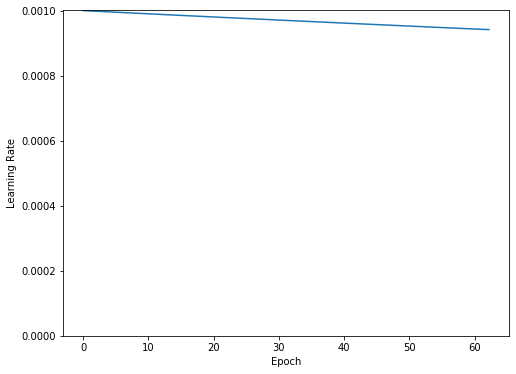

In [51]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [52]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [66]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000, verbose=0):
  if optimizer is None:
    optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

    model.summary()

    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=verbose)
    return history

### Tiny model

Start by training a model:

In [67]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [68]:
size_histories = {}

In [69]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                1584      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5185,  binary_crossentropy:1.5796,  loss:1.5796,  val_accuracy:0.5044,  val_binary_crossentropy:1.0292,  val_loss:1.0292,  
.........

KeyboardInterrupt: 

In [207]:
size_histories['Tiny'].history['binary_crossentropy']

[2.3771820068359375,
 0.8997141718864441,
 0.8829426169395447,
 0.8948631882667542,
 0.9026139974594116,
 0.8684822916984558,
 0.8804076313972473,
 0.8592902421951294,
 0.8631515502929688,
 0.8395841717720032]

Now check how the model did:

(0.5, 1)

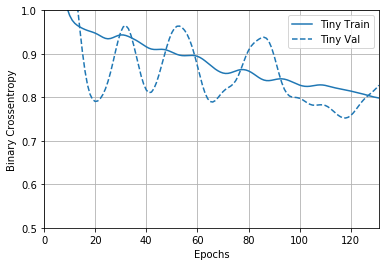

In [288]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 1])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [289]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [290]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 3,377
Trainable params: 3,377
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5017,  binary_crossentropy:3.0077,  loss:3.0077,  val_accuracy:0.4903,  val_binary_crossentropy:1.2180,  val_loss:1.2180,  
....................................................................................................
Epoch: 100, accuracy:0.4952,  binary_crossentropy:0.7250,  loss:0.7250,  val_accuracy:0.4727,  val_binary_crossentropy:0.7768,  val_lo

### Medium model

Now try 3 hidden layers with 64 units each:

In [291]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [292]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4975,  binary_crossentropy:3.1182,  loss:3.1182,  val_accuracy:0.4716,  val_binary_crossentropy:6.2460,  val_loss:6.2459,  
....................................................................................................


### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [293]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [294]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4933,  binary_crossentropy:5.5722,  loss:5.5722,  val_accuracy:0.4716,  val_binary_crossent

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

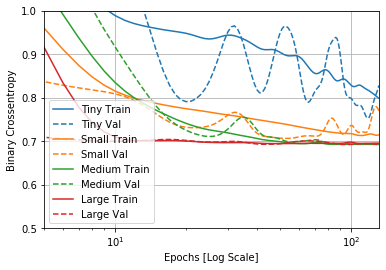

In [295]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

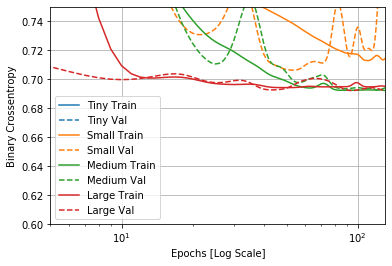

In [301]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 0.75])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

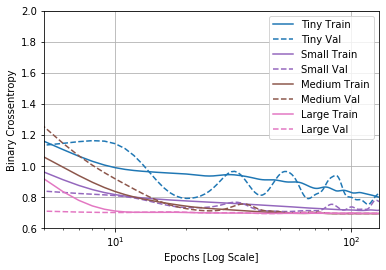

In [328]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 2])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

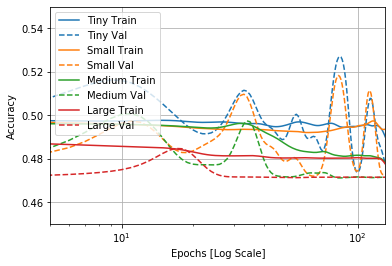

In [305]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.45, 0.55])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [306]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/fstri/AppData/Local/Temp/tmpcqha_tac/tensorboard_logs/regularizers/Tiny')

In [307]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [309]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4972,  binary_crossentropy:5.1431,  loss:6.4530,  val_accuracy:0.5274,  val_binary_crossent

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.45, 0.55)

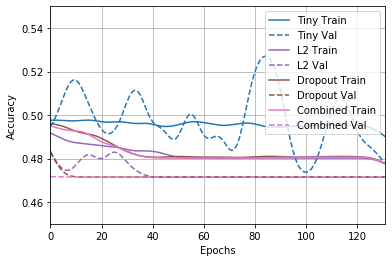

In [320]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [311]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [312]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)             

(0.45, 0.55)

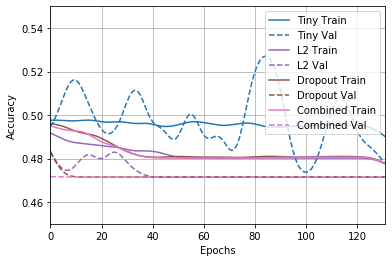

In [319]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [314]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)             

(0.45, 0.55)

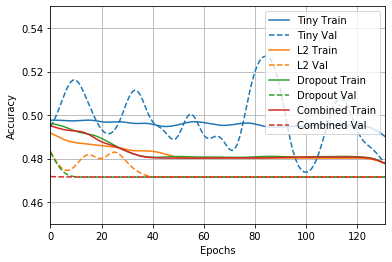

In [324]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

(0.6, 3)

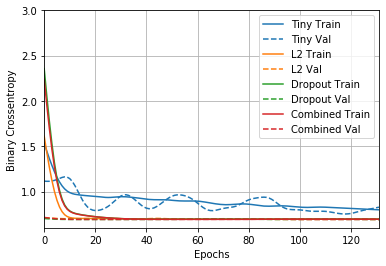

In [325]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 3])

(0.6, 0.95)

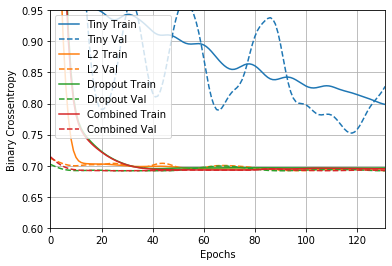

In [326]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 0.95])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.